# Install and setup
This Notebook allows to read the POLA rates as a time series in ASCII format, plot and compute the Lomb-Scargle periodogram etc. etc.

It was created on Macosx with python3 and X-code.
Further packages to be installed:

  - pip3 install matplotlib # (already including numpy)
  - pip3 install scipy pandas gatspy
  - pip3 install notebook

On macosx, run the notebook from a terminal with one of the following:
- jupyter notebook
- python3 -m notebook

The notebook will open in the browser.

In [1]:
#--------------------------------------------------------------------------#
# POLA rates : Time Series analysis
# - preparing definitions and loading subroutines
# 
# 
# 
#--------------------------------------------------------------------------#

import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as md
import math
import pandas
import scipy.signal  #for spectral density etc.
#from numpy.fft import fft, ifft   #not used in this version
#import re  #not used in this version
#from scipy.ndimage.interpolation import shift


#----------- functions to convert datetime to the MJD ---------#
# Note: all astronomical software like gatspy uses Modified Julian Date 
# so this routine is needed to feed gatspy API with the correct format
def datetime_to_mjd(date):
    year=date.year
    month=date.month
    ho=date.hour
    mi = date.minute
    se=date.second
    ms=date.microsecond
    days = se+(ms/1.e6)
    days = mi + (days / 60.)
    days = ho + (days / 60.)
    days = days / 24.

    days = date.day +days
    if month == 1 or month == 2:
        yearp = year - 1
        monthp = month + 12
    else:
        yearp = year
        monthp = month
    
    # this checks where we are in relation to October 15, 1582, the beginning
    # of the Gregorian calendar.
    if ((year < 1582) or
        (year == 1582 and month < 10) or
        (year == 1582 and month == 10 and days < 15)):
        # before start of Gregorian calendar
        B = 0
    else:
        # after start of Gregorian calendar
        A = math.trunc(yearp / 100.)
        B = 2 - A + math.trunc(A / 4.)
        
    if yearp < 0:
        C = math.trunc((365.25 * yearp) - 0.75)
    else:
        C = math.trunc(365.25 * yearp)
        
    D = math.trunc(30.6001 * (monthp + 1))
    
    jd = B + C + D + days + 1720994.5
    mjd = jd-2400000.5
    
    return mjd


#----------------- Routines to read RATES -------------- ---------------------#


#--- moving_average is available in numpy.
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w


#----------- reading rate from file (rates extracted from recon2)---------------#
# format:
# unixtime rate pressure temperature runid datetime
# 1559002997.5 32.3934440613 1019.14331055 17.318157196 391393366 2019-05-28 02:23:17.500000
# 1559003058.5 31.6065578461 1019.14331055 17.318157196 391393366 2019-05-28 02:24:18.500000

def read_rate(filename,datastart,datanow):
    print("Reading %s" % filename)
    rate = []
    sec = []
    pres = []
    temp = []
    with open(filename) as file:
        for line in file:
            line = line.strip() #preprocess line
            if not line.startswith('#'):  #skipping commented lines
                (epo,rat,pre,tem,runid,dat,tim)=line.split()
                if (float(epo)<datastart or float(epo)>datanow):
                   #print ('skipping line ',line)
                   continue
                else:
                   sec.append(float(epo))
                   if (700.0 <= float(pre) <= 1100.):
                      fpre = float(pre)
                   else:
                      fpre = np.nan
                   pres.append(fpre)
                   if (-50.0 <= float(tem) <= 100.0):
                      ftem = float(tem)
                   else:
                      ftem = np.nan
                   temp.append(ftem)
                   #if (0.1 <= float(rat) <= 90.0):
                   if (25 <= float(rat) <= 40.0):
                      frat=float(rat)
                      if (700.0 <= float(pre) <= 1100.): # pressure correction! Pressure not available for P4 [autumn 2022 - now january 2023]
                         frat=frat/math.exp(-0.002*(fpre-1000))
                      else:
                         frat=np.nan
                   else:
                      frat=np.nan
                   rate.append(frat)
 
    #-- building an array of datetime from epoch
    dates=[datetime.fromtimestamp(float(ts)) for ts in sec]
    datenums=md.date2num(dates)
    nrate = np.array(rate,dtype=float) #rate, converting list to numpy array
    npres = np.array(pres,dtype=float) #pressure, converted to numpy array
    ntemp = np.array(temp,dtype=float) #temperature, converted to numpy array
    #--difference, relative difference
    #avg = np.average(nrate)
    avg = np.nanmean(nrate)
    diffe = (nrate - avg)*100.0/avg

    #-----commenting this, we'll do it with other techniques below
    #-- adding moving average 10 30 60 minutes
    #nrate10 = moving_average(nrate,10)
    #nrate30 = moving_average(nrate,30)
    #nrate60 = moving_average(nrate,60)
    
    #-- building dataframe with all data
    # Warning: don't use the string diff!!!
    #pdf=pandas.DataFrame( {'datetimep':dates,'rate':nrate,'pres':npres,'temp':ntemp,'dif':diffe,'ma10':nrate10,'ma30':nrate30,'ma60':nrate60}, columns=['datetimep','rate','pres','temp','dif','ma10','ma30','ma60'])
    pdf=pandas.DataFrame( {'datetimep':dates,'rate':nrate,'pres':npres,'temp':ntemp,'dif':diffe}, columns=['datetimep','rate','pres','temp','dif'])
    #--convert the dataframe index to a datetime index
    pdf['datetime'] = pandas.to_datetime(pdf['datetimep'])
    pdf = pdf.set_index('datetime')
    pdf.drop(['datetimep'],axis=1,inplace=True)
    #pdf.info()
    return pdf
#----------- end reading rate from file -----------#



#----------- reading 'new' rate from file ---------------#
# format:
# unixtime rate rateRaw rate1 rate2 pressure pressure2 datetime
# 1559433700.5 1 33.025642 33.076923 50.461540 50.487179 1013.085449 1010.316284 37.451931 25.360319 26.062143 36.129055 39.000000 2019-06-02 02:01:40.500000
# 1559433750.0 0 32.033333 32.066666 32.250000 32.283333 1013.031067 1010.333618 37.469398 25.352760 26.072168 36.135315 60.000000 2019-06-02 02:02:30.000000

def read_new_rate(filename,datastart,datanow):
    print("Reading %s" % filename)

    #
    dd = 3 # <----------- max difference allowed between successive rates
    #
    rate =    []  # from root file
    rateOk =  []  # <---------------- only when sts=0
    rateOk1 = []  # <---------------- only when sts=0, rate>25, and diff between value and value-1 or value+1 is <dd
    rateRaw = []  # from root file
    rate1 =   []  # from root file
    rate2 =   []  # from root file
    # ========> rateOk1 is the cleanest one
    sec =     []
    pres =    []
    pres2 =   []
    status =  []
    excluded = 0
    valid    = 0
    with open(filename) as file:
        for line in file:
            line = line.strip() #preprocess line
            if not line.startswith('#'):  #skipping commented lines
                (epo,sts,rat,ratw,rat1,rat2,pre,pre2,t1,t2,t3,t4,dur,dat,tim)=line.split()
                if (float(epo)<datastart or float(epo)>datanow):
                   #print ('skipping line ',line)
                   continue
                else:
                   sec.append(float(epo))
                   status.append(int(sts))
                   frat=float(rat)
                   fraw=float(ratw)
                   fra1=float(rat1)
                   fra2=float(rat2)
                   fpre=float(pre)
                   fpr2=float(pre2)
                   if (700.0 <= float(pre) <= 1100.): # pressure correction! Pressure1 not available for P4 [autumn 2022 - now january 2023]
                      frat=frat/math.exp(-0.002*(fpre-1000))
                      fraw=fraw/math.exp(-0.002*(fpre-1000))
                      fra1=fra1/math.exp(-0.002*(fpre-1000))
                      fra2=fra2/math.exp(-0.002*(fpre-1000))
                   elif (700.0 <= fpr2 <= 1100.): # pressure correction with the second sensor
                      frat=frat/math.exp(-0.002*(fpr2-1000))
                      fraw=fraw/math.exp(-0.002*(fpr2-1000))
                      fra1=fra1/math.exp(-0.002*(fpr2-1000))
                      fra2=fra2/math.exp(-0.002*(fpr2-1000))
                   else:
                      frat=np.nan
                      fraw=np.nan
                      fra1=np.nan
                      fra2=np.nan
                   #if (frat>40):
                   #   print(line)
                   #if (int(sts)==0):
                   #   frok = frat
                   #   if (frok<20):
                   #      print(line)
                   #else:
                   #   frok = np.nan
                                       
                   if (int(sts)>0):
                      frok = np.nan
                      frok1 = np.nan
                   elif (int(sts)==0) and ((abs(frat-fraw)>dd or abs(frat-fra1)>dd or abs(frat-fra2)>dd or abs(fraw-fra1)>dd or abs(fraw-fra2)>dd or abs(fra1-fra2)>dd)  ):
                      #print(line)
                      frok1 = np.nan
                      frok = frat
                      excluded = excluded+1
                   elif (frat<25):
                      frok1 = np.nan
                      frok = frat
                      excluded = excluded+1
                   else:
                      frok=frat
                      frok1=frat
                      valid = valid+1
                      #if (frat<28):
                      #   print(line)

                   rate.append(frat)     #all
                   rateOk.append(frok)   #all with status=ok
                   rateOk1.append(frok1) #clean
                   rateRaw.append(fraw)  #second value of rate
                   rate1.append(fra1)    #rate1 (another value of rate, maybe from Nicola)
                   rate2.append(fra2)    #rate2 (another value of rate, "")
                   pres.append(fpre)
                   pres2.append(fpr2)
    #-- building an array of datetime from epoch
    dates=[datetime.fromtimestamp(float(ts)) for ts in sec]
    datenums=md.date2num(dates)
    nrate = np.array(rate,dtype=float) #converting list to numpy array
    nratk = np.array(rateOk,dtype=float) #converting list to numpy array
    nrak1 = np.array(rateOk1,dtype=float) #converting list to numpy array
    nratw = np.array(rateRaw,dtype=float) #converting list to numpy array
    nrat1 = np.array(rate1,dtype=float) #converting list to numpy array
    nrat2 = np.array(rate2,dtype=float) #converting list to numpy array
    npres = np.array(pres,dtype=float) #pressure, converted to numpy array
    npre2 = np.array(pres2,dtype=float) #pressure, converted to numpy array
    nstat = np.array(status,dtype=float) #pressure, converted to numpy array
    #--difference, relative difference
    #avg = np.average(nrate)
    avg = np.nanmean(nrate)
    diffe = (nrate - avg)*100.0/avg

    #-- adding moving average 10 30 60
    #nrate10 = moving_average(nrate,10)
    #nrate30 = moving_average(nrate,30)
    #nrate60 = moving_average(nrate,60)
    #-- building dataframe with all data
    #pdf=pandas.DataFrame( {'datetimep':dates,'rate':nrate,'pres':npres,'temp':ntemp,'dif':diffe}, columns=['datetimep','rate','pres','temp','dif'])
    #pdf=pandas.DataFrame( {'datetimep':dates,'rateOk':nratk,'rateOk1':nrak1,'rate':nrate,'rateRaw':nratw,'rate1':nrat1,'rate2':nrat2,'pres':npres,'pres2':npre2,'status':nstat}, columns=['datetimep','rateOk','rateOk1','rate','rateRaw','rate1','rate2','pres','pres2','status'])
    #--- let's call 'rate' the one to be used, for unifority with the old recon2 data
    #
    # this was a good line with all values
    #pdf=pandas.DataFrame( {'datetimep':dates,'rateOk':nratk,'rateOk1':nrak1,'rate':nrate,'rateRaw':nratw,'rate1':nrat1,'rate2':nrat2,'pres':npres,'pres2':npre2,'status':nstat}, columns=['datetimep','rateOk','rateOk1','rate','rateRaw','rate1','rate2','pres','pres2','status'])

    pdf=pandas.DataFrame( {'datetimep':dates,'rate':nrak1,'pres':npres,'pres2':npre2,'status':nstat}, columns=['datetimep','rate','pres','pres2','status'])
    #--convert the dataframe index to a datetime index
    pdf['datetime'] = pandas.to_datetime(pdf['datetimep'])
    pdf = pdf.set_index('datetime')
    pdf.drop(['datetimep'],axis=1,inplace=True)
    #pdf.info()
    print(" -- Valid = ",valid,", excluded = ",excluded,", % = ",excluded*100.0/(valid+excluded),", dd = ",dd)
    return pdf



#---- removing NaN from arrays
def removing_nan(t1,r1):
    #ss=[]
    rr=[]
    tt=np.zeros((0), dtype='datetime64[s]')
    #mm=[]
    #er=[]

    removedNaN=0
    for i in range(0,len(r1)):
        #print(i,r1[i],np.isnan(r1[i]))
        #if (np.isnan(r1[i]) or np.isnan(er1[i])):
        if (np.isnan(r1[i])):
            #skipping NaN value
            #print('Skipping NaN:  i=',i,', r1=',r1[i])
            removedNaN=removedNaN+1
        else:
            #print('Keeping value:  i=',i,', r1=',r1[i],', t1=',t1[i])
            #ss=np.append(ss,s1[i])
            tt=np.append(tt,t1[i])
            #mm=np.append(mm,m1[i])
            rr=np.append(rr,r1[i])
            #er=np.append(er,er1[i])
    print(' -- rate values = ',len(r1))
    print(' -- >> removed NaN values = ',removedNaN)
    print(' -- valid rate values = ',len(rr))
    return tt,rr

#----------- end reading rate from file -----------#


def build_array_of_statistical_errors(r1):
    #----------- building an array of statistical errors

    #--- building an array with differences: d1[i] = rate[i]-rate[i-1]
    d1 = []
    d1.append(0.0)
    for i in range(1, len(r1)):
        if np.isnan(r1[i]):
            d1.append(np.NaN)
        else:
            j=1
            #print("r1[i]=",r1[i], "r1[i-j]=",r1[i-j])
            while np.isnan(r1[i-j]):
                j=j+1

            #d1.append((r1[i]-r1[i-j])*j)  # (note: when we jump more than j=1, I multiply the error by j)
            d1.append((r1[i]-r1[i-j]))  

    #--doing the same but 'forward'
    d1f = []
    for i in range(0, len(r1)-2):
        if np.isnan(r1[i]):
            d1f.append(np.NaN)
        else:
            j=1
            #print("r1[i]=",r1[i], "r1[i-j]=",r1[i-j])
            while np.isnan(r1[i+j]):
                j=j+1

            #d1f.append((r1[i]-r1[i-j])*j)  # (note: when we jump more than j=1, I multiply the error by j)
            d1f.append((r1[i]-r1[i+j]))  
    d1f.append(0.0)

    #for i in range(1, min(10,len(r1))):  #printing the first m elements
    #    print("%5d\t%d\t%s\t%7.3f\t%7.3f\t%7.4f\t%7.4f" % (i,s1[i],t1[i],m1[i],r1[i],d1[i],d1f[i]))

    #-------- set this to True to plot the histogram 
    do_plot_histo_differences=False
    if (do_plot_histo_differences==True):
        #------- compute mean and standard dev of the differences (of d1 only for the moment)
        print("entries = ",np.count_nonzero(~np.isnan(d1)))
        print("mean = ",np.nanmean(d1))
        print("stddev = ",np.nanstd(d1))
        #---- building the histogram of the differences
        #bs = np.arange(-10.0,10.0,0.1)  #-- good for original rates, one per minute
        bs = np.arange(-1.0,1.0,0.05)  #-- good for daily rates
        plt.hist(d1, bins = bs) 
        plt.yscale('log')
        #plt.text(-0.8, 30, f'entries : {np.count_nonzero(~np.isnan(d1)):.0f}')
        #plt.text(-0.8, 20, f'mean : {np.nanmean(d1):.3f}')
        #plt.text(-0.8, 15, f'std : {np.nanstd(d1):.3f}')
        plt.title("Differences histogram") 
        print('Done with difference histogram.')
 
    #---definining the err_stat from std, and error array er1 
    stddevd = np.nanstd(d1)
    err_stat = stddevd/math.sqrt(2)
    #print('err_stat=',err_stat)

    er1 = []
    er1.append(err_stat)
    for i in range(1, len(r1)-1):
        if np.isnan(r1[i]):
            er1.append(np.NaN)
        else:
            er1.append( max( err_stat , min( abs(d1[i]) , abs(d1f[i]) ) ))

    er1.append(err_stat)
    #print("    i        epoch                            date      rateOk1      d1     d1f     er1" )
    #for i in range(1, min(20,len(r1))):  #printing the first m elements
    #    print("%5d\t%d\t%s\t%7.3f\t%7.4f\t%7.4f\t%7.4f" % (i,s1[i],t1[i],r1[i],d1[i],d1f[i],er1[i]))
    print('Done preparing error array, entries=',len(er1))
    return er1

#-------------------------------------------------#

print('Libraries loaded.') 


Libraries loaded.


# Start of the real program.

Settings needed:
- dates can be left like this to load the full time series, and tuned on the single plots.
- path for ASCII files *MUST* be personalized
  - filenames MUST also be adapted (I'm using P1.txt, P3.txt, ..., or P1-newrate.txt ecc.)
- resampling can be set, to reduce computation time, especially when doing the "running periodogram"
- when resampling, use strings like 1h, 6h, 1d, 1min, ... and adapt the nyquist factor

The original values are sampled 1-per-minute.
Note that one day sampling ('1d') is appropriate and fast to evaluate 1-year periodicity.

- Lines that should be adapted are marked with an inline comment and an arrow    # <--------

The block is reading the time series, building the average rate, computing statistical errors.

At the end, we have:  (a=average, 1=POLA1, 3=POLA3, 4=POLA4)
- ma  (time, in format of array of MJD)
- ta  (time array)
- sa  (time, in format f unix time)
- ra  (array of average rates)
- era (array of statistical errors)

In [2]:
datanya2019 = 1559080800 # 2019-05-29 00:00:00
datastart = datanya2019
#datanow =  (datetime(2021,6,30,23,59) -datetime(1970,1,1)).total_seconds()
datanow =  (datetime(2023,10,31,23,59) -datetime(1970,1,1)).total_seconds()

filepath = '/Users/opinazza/cernbox/POLAR/analisi/rate/new_recon/'  # <------  new/recon2
#filepath = '/Users/opinazza/cernbox/POLAR/analisi/rate/'

resampling = '1d'                             #  <------------
#nyquist = 1./2./24    #this is for 1h
#nyquist = 0.5*6./24   #this is for 6h
#nyquist = 0.5*12./24  #this is for 12h
nyquist = 0.5         #this is for 1d
#nyquist = 0.5/24./60.   #this is for 1min

read_pola1=True                               # <----------  Change to False to avoid loading one or more files
read_pola3=True
read_pola4=True

#------------- POLA-1---------------#
if read_pola1==True:
    p1df = read_new_rate(filepath+"P1-newrate.txt",datastart,datanow)     # <------- adapt file name
    #p1df = read_rate(filepath+"P1.txt",datastart,datanow)
    #p1df.info()
    #print(p1df)

    #--resampling (to reduce data)
    p1df_resampled=p1df.resample(resampling).mean()

    #--extracting time and rate
    ra1 = p1df_resampled['rate'].values
    ta1 = np.array(p1df_resampled.index.to_pydatetime(), dtype=np.datetime64)
    t1,r1 = removing_nan(ta1,ra1)
    s1 = (t1.astype(np.int64))/1e6

    #--- using MJD times
    #from datetime import datetime  #already loaded above
    m1 = np.array([])
    for i in range(0,len(s1)):
        dt=datetime.fromtimestamp(s1[i])
        mjdop = datetime_to_mjd(dt)
        m1=np.append(m1,mjdop)
else:
    print('Skipping POLA-1')
        
#------------- POLA-3---------------#
if read_pola3==True:
    p3df = read_new_rate(filepath+"P3-newrate.txt",datastart,datanow)   #<----- adapt file name
    #p3df = read_rate(filepath+"P3.txt",datastart,datanow)
    #p1df.info()
    #print(p1df)
    
    #------increasing POLA-3 rate by 1.5%
    p3df.loc[:,'rate'] *= 1.015    

    #--resampling (to reduce data)
    #p1df_1day=p1df.resample('1d').mean()
    #p1df_1day=p1df.resample('1h').mean()
    p3df_resampled=p3df.resample(resampling).mean()

    #trying to extract time and rate (cleanest rate is rateOk1)
    ra3 = p3df_resampled['rate'].values
    ta3 = np.array(p3df_resampled.index.to_pydatetime(), dtype=np.datetime64)
    t3,r3 = removing_nan(ta3,ra3)
    s3 = (t3.astype(np.int64))/1e6

    #--- using MJD times
    #from datetime import datetime  #already loaded above
    m3 = np.array([])
    for i in range(0,len(s3)):
        dt=datetime.fromtimestamp(s3[i])
        mjdop = datetime_to_mjd(dt)
        m3=np.append(m3,mjdop)
else:
    print('Skipping POLA-3')

#------------- POLA-4---------------#
if read_pola4==True:
    p4df = read_new_rate(filepath+"P4-newrate.txt",datastart,datanow)   # <-- adapt file name
    #p4df = read_rate(filepath+"P4.txt",datastart,datanow)
    #p1df.info()
    #print(p1df)

    #--resampling (to reduce data)
    #p1df_1day=p1df.resample('1d').mean()
    #p1df_1day=p1df.resample('1h').mean()
    p4df_resampled=p4df.resample(resampling).mean()

    #trying to extract time and rate (cleanest rate is rateOk1)
    ra4 = p4df_resampled['rate'].values
    ta4 = np.array(p4df_resampled.index.to_pydatetime(), dtype=np.datetime64)
    t4,r4 = removing_nan(ta4,ra4)
    s4 = (t4.astype(np.int64))/1e6

    #--- using MJD times
    #from datetime import datetime  #already loaded above
    m4 = np.array([])
    for i in range(0,len(s4)):
        dt=datetime.fromtimestamp(s4[i])
        mjdop = datetime_to_mjd(dt)
        m4=np.append(m4,mjdop)
else:
    print('Skipping POLA-4')

print('Resampling by: ',resampling)
print('Nyquist = ',nyquist)
print('Done reading POLA rates.')



#------------------------#
computing_average=True
if computing_average==True:
    print('Computing average rate')
    if (read_pola1==True):
        if (read_pola3==True and read_pola4==True):
            pdf=pandas.concat([p1df, p3df, p4df]).groupby('datetime', as_index=True).mean()
        elif (read_pola3==True and read_pola4==False):
            pdf=pandas.concat([p1df, p3df]).groupby('datetime', as_index=True).mean()
        elif (read_pola3==False and read_pola4==True):
            pdf=pandas.concat([p1df, p4df]).groupby('datetime', as_index=True).mean()
        else:
            pdf=p1df
    else:
        if (read_pola3==True and read_pola4==True):
            pdf=pandas.concat([p3df, p4df]).groupby('datetime', as_index=True).mean()
        elif (read_pola3==True and read_pola4==False):
            pdf=p3df
        elif (read_pola3==False and read_pola4==True):
            pdf=p4df
        else:
            print('Error: no dataset selected.')
    #pdf.info()
    #print (pdf)
    pdf_resampled=pdf.resample(resampling).mean()

    #trying to extract time and rate 
    rav = pdf_resampled['rate'].values 
    tav = np.array(pdf_resampled.index.to_pydatetime(), dtype=np.datetime64)
    ta,ra = removing_nan(tav,rav)
    sa = (ta.astype(np.int64))/1e6

    #--- using MJD times
    #from datetime import datetime  #already loaded above
    ma = np.array([])
    for i in range(0,len(sa)):
        dt=datetime.fromtimestamp(sa[i])
        mjdop = datetime_to_mjd(dt)
        ma=np.append(ma,mjdop)
    #print(len(sa),len(ta),len(ma),len(ra))
else:
    print('Skipping average rate')


#--------------  ----------------#
if read_pola1==True:
    print('Number of values : POLA-1=',len(r1))
if read_pola3==True:
    print('                   POLA-3=',len(r3))
if read_pola4==True:
    print('                   POLA-4=',len(r4))
if computing_average==True:
    print('                   Average=',len(ra))

    
    
#------- computing array of statistical errors
if read_pola1==True:
    er1 = build_array_of_statistical_errors(r1)
if read_pola3==True:
    er3 = build_array_of_statistical_errors(r3)
if read_pola4==True:
    er4 = build_array_of_statistical_errors(r4)
if computing_average==True:
    era = build_array_of_statistical_errors(ra)

print('Done preparing error arrays.')
print('Done reading data for POLA-1, POLA-3, POLA-4, and averaging datasets.')
print('Done.')

Reading /Users/opinazza/cernbox/POLAR/analisi/rate/new_recon/P1-newrate.txt
 -- Valid =  1035178 , excluded =  27210 , % =  2.5612111582585646 , dd =  3
 -- rate values =  1522
 -- >> removed NaN values =  583
 -- valid rate values =  939
Reading /Users/opinazza/cernbox/POLAR/analisi/rate/new_recon/P3-newrate.txt
 -- Valid =  1534217 , excluded =  31795 , % =  2.030316498213296 , dd =  3
 -- rate values =  1522
 -- >> removed NaN values =  163
 -- valid rate values =  1359
Reading /Users/opinazza/cernbox/POLAR/analisi/rate/new_recon/P4-newrate.txt
 -- Valid =  1210509 , excluded =  16508 , % =  1.3453766329235863 , dd =  3
 -- rate values =  1522
 -- >> removed NaN values =  453
 -- valid rate values =  1069
Resampling by:  1d
Nyquist =  0.5
Done reading POLA rates.
Computing average rate
 -- rate values =  1522
 -- >> removed NaN values =  5
 -- valid rate values =  1517
Number of values : POLA-1= 939
                   POLA-3= 1359
                   POLA-4= 1069
                   A

Next block will plot the rate.

Done with rate plot.


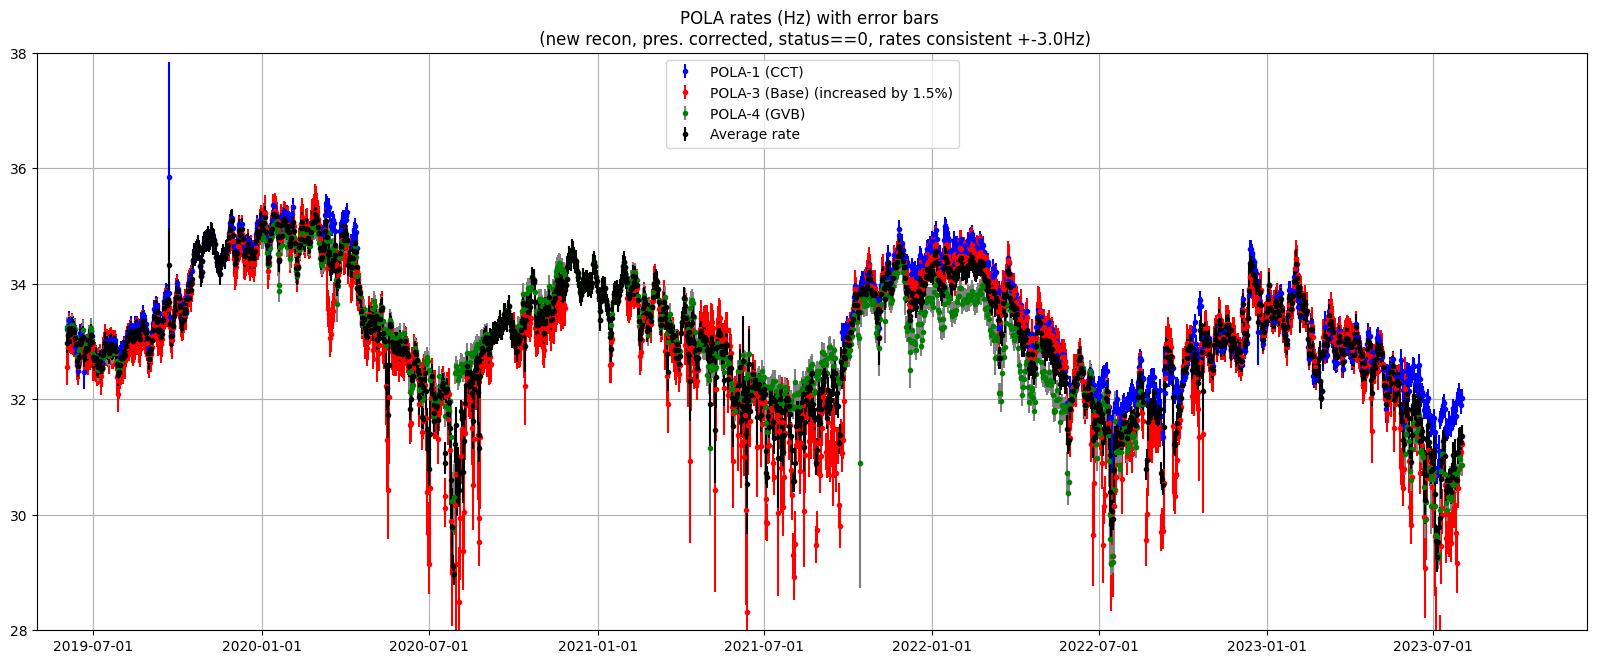

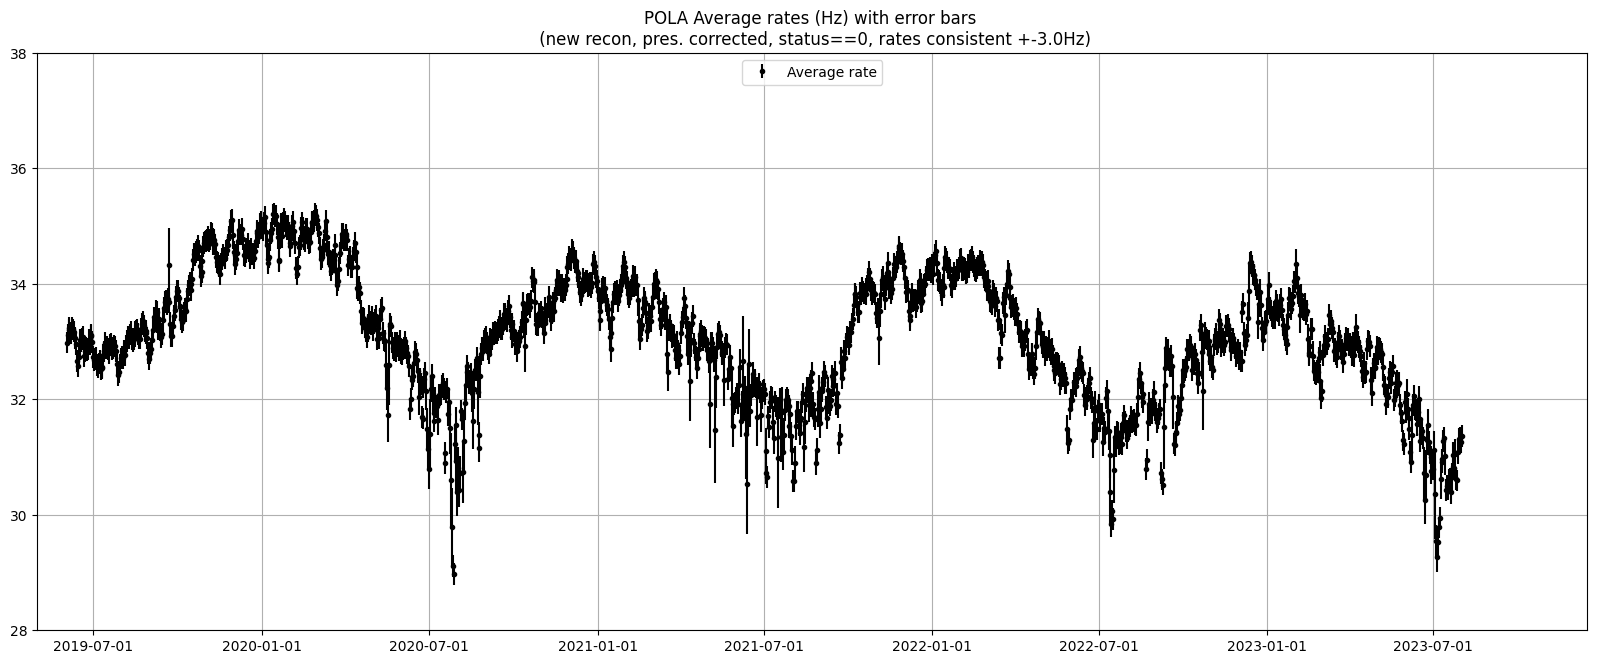

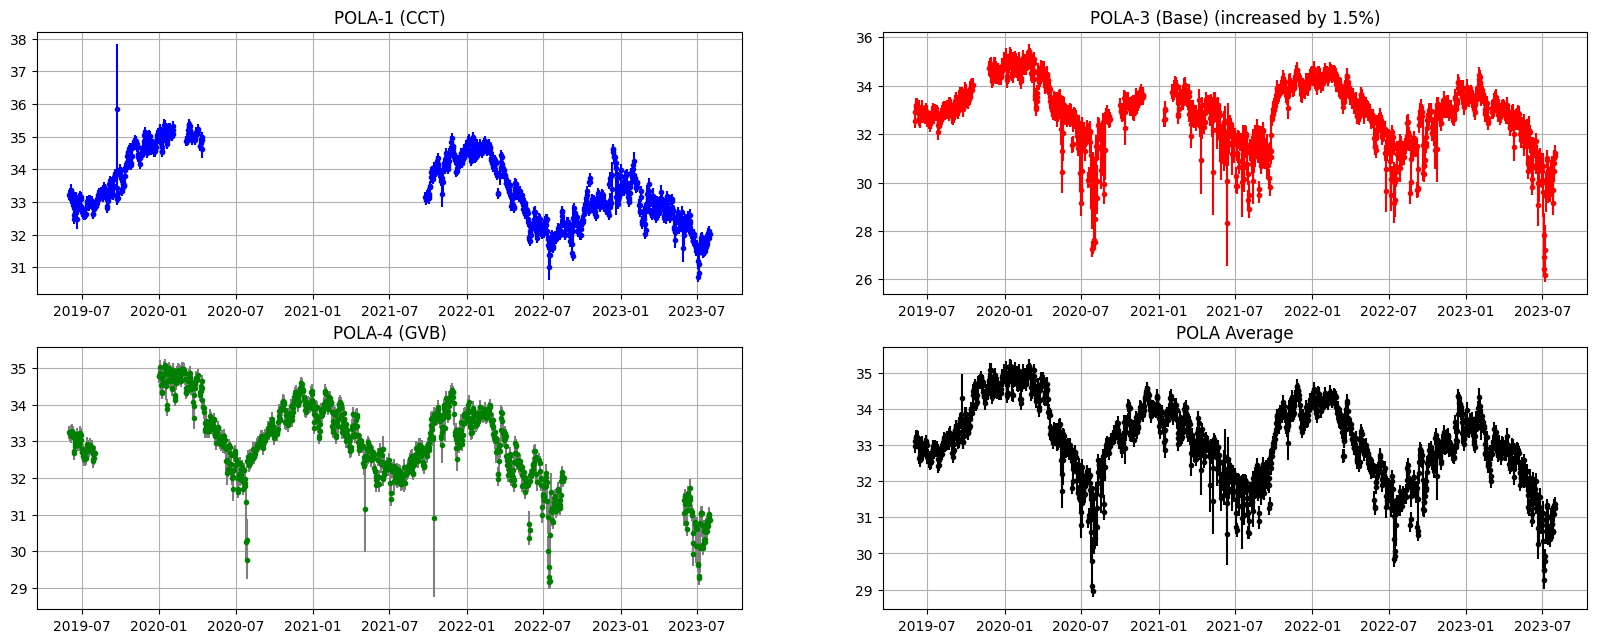

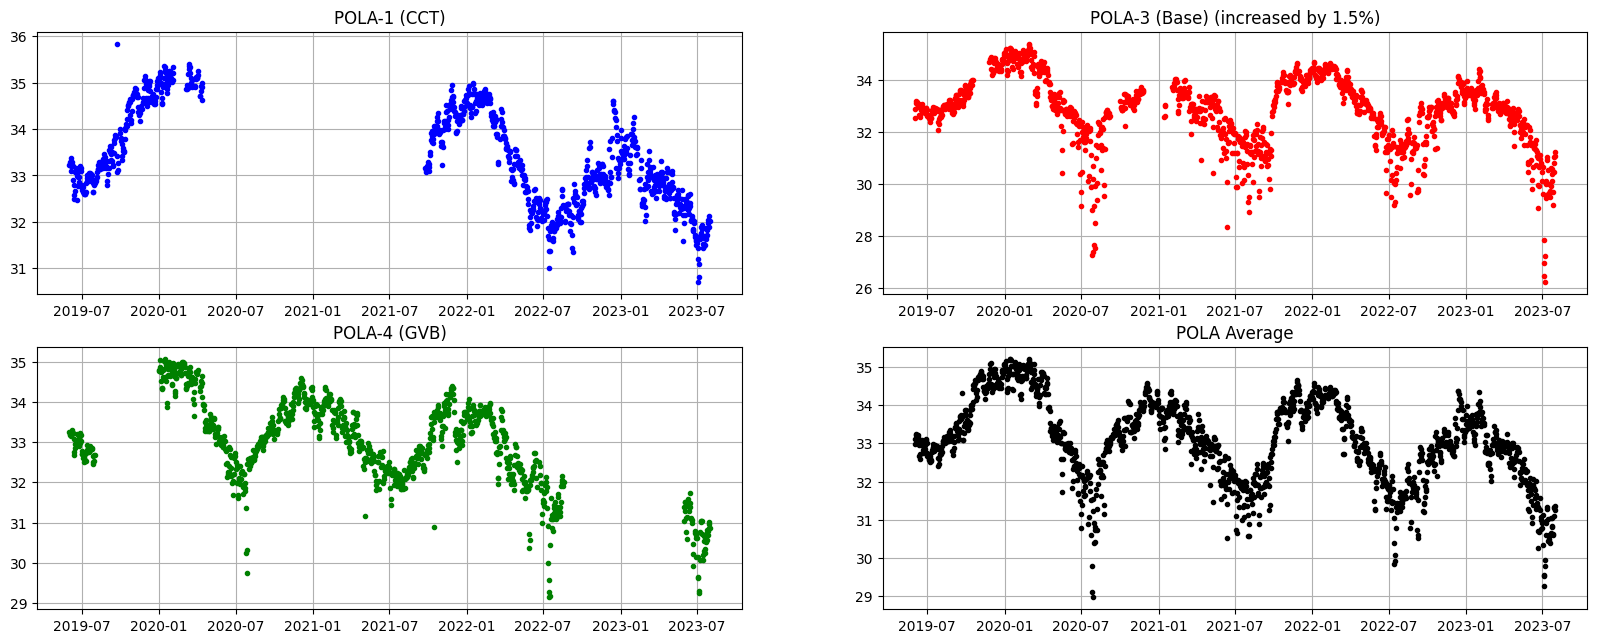

In [3]:
#--------- now we can plot POLA rates with error bars
#-- configure x-axis to show date labels
#import seaborn; seaborn.set() 

plt.rcParams["figure.figsize"] = (20,7.5)
fig, ax = plt.subplots()


#----- [1] plot of the 3 rate plus the average, all together -------#
#plt.title("POLA-1/3/4 (Hz) with error bars \n (new recon, pres. corrected, status==0, rates consistent +-2.5Hz)")
plt.title("POLA rates (Hz) with error bars \n (new recon, pres. corrected, status==0, rates consistent +-3.0Hz)")
#plt.title("POLA rates (Hz) with error bars \n (recon2, pres. corrected, 6h average)")
ax.set_ylim(28,38)
if read_pola1==True:
    plt.errorbar(t1,r1, yerr=er1, fmt='.', ecolor='blue', capsize=0, color='blue',label="POLA-1 (CCT)")
if read_pola3==True:
    plt.errorbar(t3,r3, yerr=er3, fmt='.', ecolor='red',  capsize=0, color='red', label="POLA-3 (Base) (increased by 1.5%)")
if read_pola4==True:
    plt.errorbar(t4,r4, yerr=er4, fmt='.', ecolor='gray', capsize=0, color='green',label="POLA-4 (GVB)")

if computing_average==True:
    plt.errorbar(ta,ra, yerr=era, fmt='.', ecolor='black', capsize=0, color='black',label="Average rate")
plt.grid(visible=True)
#plt.text(datetime(2019,8,1,10,0),41,"Zoom over 6 hours")  #-- zooming might be necessary with original rates
plt.legend(loc='upper center')
#plt.xlim(datetime(2022,9,1,0,0),datetime(2022,11,1,23,59))
#plt.xlim(datetime(2019,8,1,8,0),datetime(2019,8,1,14,0))  #-- zooming might be necessary with original rates
plt.xlim(datetime(2019,5,1,0,0),datetime(2023,12,15,23,59))
#xfmt = md.DateFormatter('%Y-%m-%d\n%H:%M')
xfmt = md.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)


#---------------- [2] Plot of the average rate only -----------------------#
fig, ax = plt.subplots()
#plt.title("POLA Average rates (Hz) with error bars \n (new recon, pres. corrected, 6h average)")
plt.title("POLA Average rates (Hz) with error bars \n (new recon, pres. corrected, status==0, rates consistent +-3.0Hz)")
ax.set_ylim(28,38)

if computing_average==True:
    plt.errorbar(ta,ra, yerr=era, fmt='.', ecolor='black', capsize=0, color='black',label="Average rate")
plt.grid(visible=True)
plt.legend(loc='upper center')
plt.xlim(datetime(2019,5,1,0,0),datetime(2023,12,15,23,59))
#xfmt = md.DateFormatter('%Y-%m-%d\n%H:%M')
xfmt = md.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)


#--------------[3] plot composed of 4 small subplots, with the 3 rates plus the average, with error bars
fig, axs = plt.subplots(2, 2)
axs[0, 0].errorbar(t1,r1, yerr=er1, fmt='.', ecolor='blue', capsize=0, color='blue',label="POLA-1 (CCT)")
axs[0, 0].set_title('POLA-1 (CCT)')
axs[0, 1].errorbar(t3,r3, yerr=er3, fmt='.', ecolor='red', capsize=0, color='red',label="POLA-3 (Base) (increased by 1.5%)")
axs[0, 1].set_title('POLA-3 (Base) (increased by 1.5%)')

axs[1, 0].errorbar(t4,r4, yerr=er4, fmt='.', ecolor='gray', capsize=0, color='green',label="POLA-4 (GVB)")
axs[1, 0].set_title('POLA-4 (GVB)')
axs[1, 1].errorbar(ta,ra, yerr=era, fmt='.', ecolor='black', capsize=0, color='black',label="Average rate")
axs[1, 1].set_title('POLA Average')
xfmt = md.DateFormatter('%Y-%m')
axs[0,0].xaxis.set_major_formatter(xfmt)
axs[0,0].grid()
axs[0,1].grid()
axs[1,0].grid()
axs[1,1].grid()


#--------------[4] plot composed of 4 small subplots, with the 3 rates plus the average, without error bars ----------#
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(t1,r1, '.', color='blue',label="POLA-1 (CCT)")
axs[0, 0].set_title('POLA-1 (CCT)')
axs[0, 1].plot(t3,r3, '.', color='red',label="POLA-3 (Base) (increased by 1.5%)")
axs[0, 1].set_title('POLA-3 (Base) (increased by 1.5%)')

axs[1, 0].plot(t4,r4, '.', color='green',label="POLA-4 (GVB)")
axs[1, 0].set_title('POLA-4 (GVB)')
axs[1, 1].plot(ta,ra, '.', color='black',label="Average rate")
axs[1, 1].set_title('POLA Average')
xfmt = md.DateFormatter('%Y-%m')
axs[0,0].xaxis.set_major_formatter(xfmt)
axs[0,0].grid()
axs[0,1].grid()
axs[1,0].grid()
axs[1,1].grid()


print('Done with rate plot.')



# gatspy.LombScargleFast
There are several techniques to compute the Lomb-Scargle periodogram.
This first one is very fast, bus the resolution is a bit low.
The result is shown in a normal plot and in a log-log one.

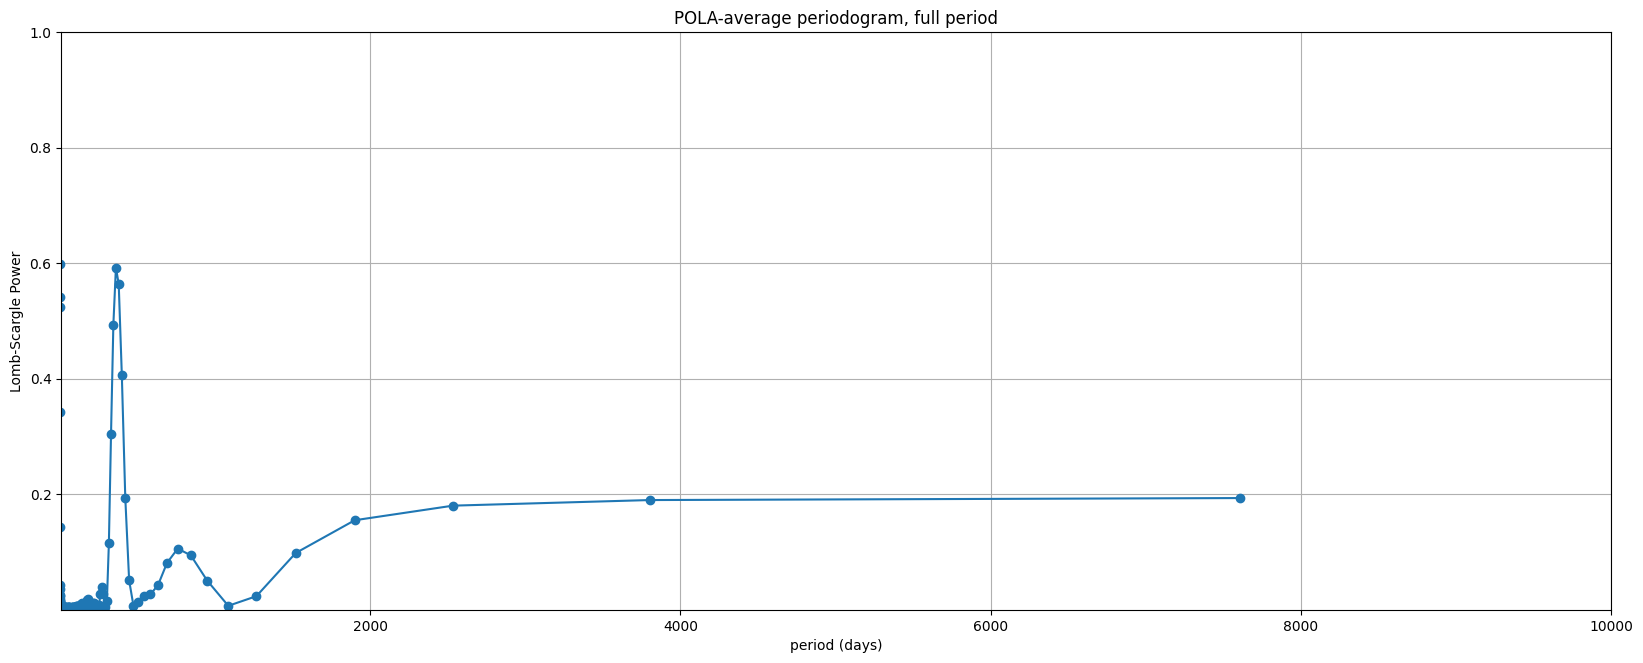

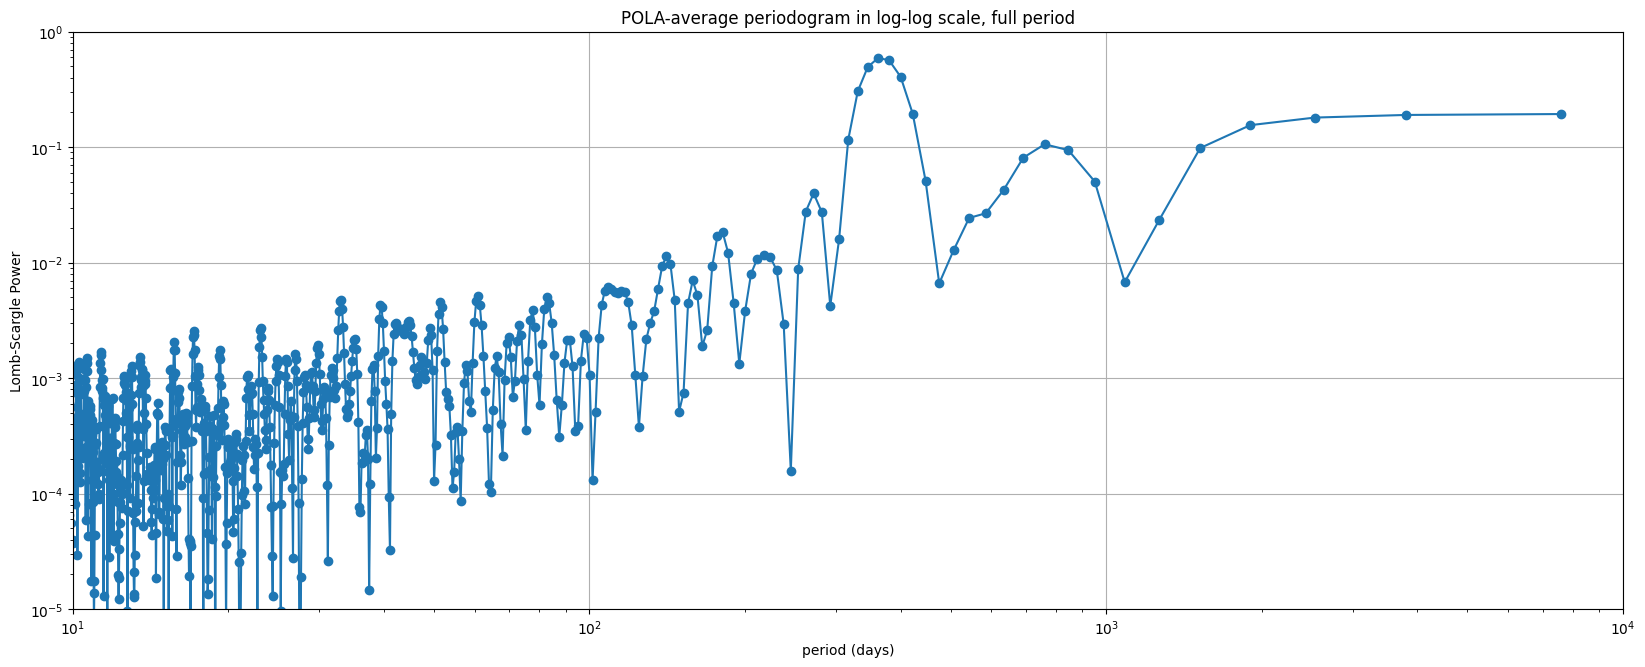

In [4]:
#------------------------------------------------------#
# The Lomb-Scargle model is essentially a least squares fit 
#  of a single sinusoid to the data.
#
#--------------- gatspy.LombScargleFast----------------#

from gatspy.periodic import LombScargleFast
model = LombScargleFast().fit(ma,ra,era)
freq, power = model.periodogram_auto(nyquist_factor=2)

fig, ax = plt.subplots()
plt.title("POLA-average periodogram, full period")
ax.plot(freq, power,'o-')
ax.grid()
#plt.xscale('log')
#plt.yscale('log')
ax.set(xlim=(10,1e4), ylim=(1e-5, 1), xlabel='period (days)', ylabel='Lomb-Scargle Power');


fig, ax = plt.subplots()
plt.title("POLA-average periodogram in log-log scale, full period")
ax.plot(freq, power,'o-')
ax.grid()
plt.xscale('log')
plt.yscale('log')
ax.set(xlim=(10,1e4), ylim=(1e-5, 1), xlabel='period (days)', ylabel='Lomb-Scargle Power');
#ax.set(xlim=(1,1200), ylim=(1e-5, 1), xlabel='period (days)', ylabel='Lomb-Scargle Power');



# gatspy.LombScargle
The _normal_ LombScargle mode can be computed over a regular grid of periods.
This binning is graphically convenient, but could miss some of the peaks. At a later step, the peak can be estimated with more precision.

Number of periods 9000 , Max period= 900.0 , Min periods= 1.0

Peaks:
i	index	days	power
0	2712	271.9	 0.04
1	3666	367.2	 0.60
2	7750	775.2	 0.11


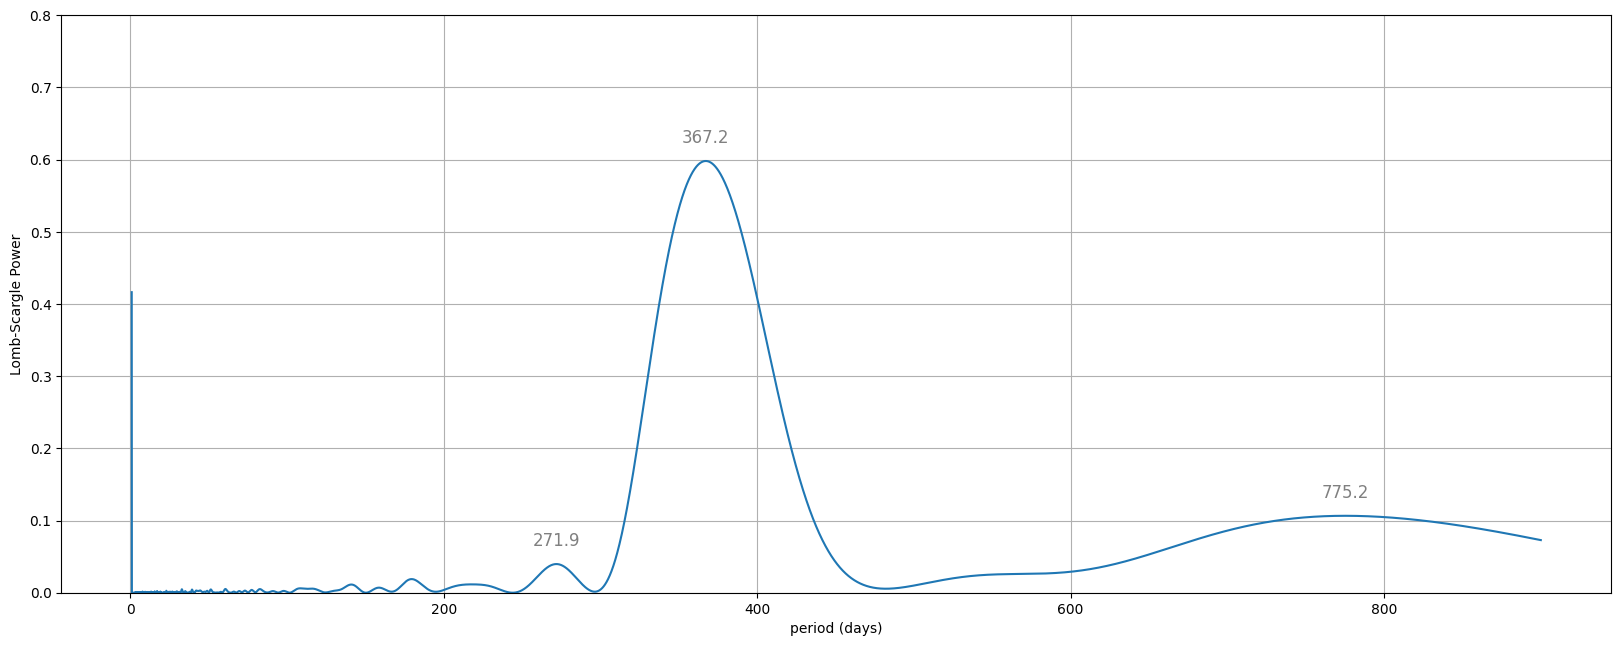

In [5]:
#------------- gatspy.LombScargle (normal)-------------#
#   the fit is better 
from gatspy.periodic import LombScargle
periods = np.linspace(1,900, 9000)

model = LombScargle(fit_offset=True).fit(ma, ra, era)
power = model.score(periods)

# plot the results
fig, ax = plt.subplots()
ax.plot(periods, power)
ax.grid()
ax.set(ylim=(0, 0.8), xlabel='period (days)',
       ylabel='Lomb-Scargle Power');

print('Number of periods',len(periods),', Max period=',max(periods),', Min periods=',min(periods))

#------ also printing peaks from this smooth periodogram
import scipy.signal
peaks = scipy.signal.find_peaks(power,height=0.02)

#print(type(peaks))
print('\nPeaks:\ni\tindex\tdays\tpower')
ind=peaks[0]
height=peaks[1]
style = dict(size=12, color='gray')
for i in range(0,len(ind)):
    print('%d\t%d\t%5.1f\t%5.2f' % (i,ind[i],periods[ind[i]],power[ind[i]]))   
    ax.text(periods[ind[i]], power[ind[i]]+0.025, round(periods[ind[i]],1), ha='center', **style)



In [7]:
#--------------- Using optimizer to better evaluate the peak ------------#
from gatspy.periodic import LombScargleFast

#---- original from paper-------#
#model = LombScargleFast().fit(t, mag, dmag)
#periods, power = model.periodogram_auto(nyquist_factor=100)
#fig, ax = plt.subplots()
#ax.plot(periods, power)
#ax.set(xlim=(0.2, 1.4), ylim=(0, 0.8),
#       xlabel='period (days)',
#       ylabel='Lomb-Scargle Power');

#--------------my LS -----------#
#model = LombScargleFast().fit(ma,ra,era)
#freq, power = model.periodogram_auto(nyquist_factor=2)
#fig, ax = plt.subplots()
#ax.plot(freq, power,'o-')
#ax.grid()
##plt.xscale('log')
##plt.yscale('log')
#ax.set(xlim=(1,1200), ylim=(1e-5, 1),
#       xlabel='period (days)',
#       ylabel='Lomb-Scargle Power');

#---------computing the best peaks using model API -------#
model = LombScargleFast(fit_period=True)
model.optimizer.period_range = (50,1000)
model.fit(ma,ra,era)
model.find_best_periods(7)
#model.best_period

#-- --> note that the apparent peak at 540 (visible with old recon2 files) has disappeared

Finding optimal frequency:
 - Estimated peak width = 0.00413
 - Using 5 steps per peak; omega_step = 0.000826
 - User-specified period range:  50 to 1e+03
 - Computing periods at 146 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00413
 - Using 5 steps per peak; omega_step = 0.000826
 - User-specified period range:  50 to 1e+03
 - Computing periods at 146 steps
Zooming-in on 14 candidate peaks:
 - Computing periods at 2800 steps


array([366.77115987, 770.12658228, 271.6556528 , 179.51138912,
       213.65360303, 141.00305924, 108.8683702 ])

Computed with model optimizer
Peaks POLA-1:  [369.26438456 722.56532067 278.62245833 201.80443147]
Peaks POLA-3:  [363.78856733 813.80417335 220.27516293 270.11188066]
Peaks POLA-4:  [351.02700208 187.15393134 223.51212344 109.55845278]
Peaks POLA-A:  [367.30258392 774.83443709 271.9470767  179.59617428]


Computed with scipy.signal

Peaks POLA-1:
0 721 73.0 0.02
1 765 77.4 0.022
2 1116 112.5 0.026
3 2010 201.8 0.027
4 2326 233.4 0.02
5 2778 278.6 0.171
6 3685 369.2 0.568
7 7224 722.9 0.404

Peaks POLA-3:
0 1321 133.0 0.023
1 2194 220.2 0.051
2 2693 270.1 0.049
3 3631 363.8 0.557
4 8136 814.0 0.145

Peaks POLA-4:
0 1086 109.5 0.044
1 1186 119.5 0.03
2 1444 145.3 0.023
3 1627 163.6 0.031
4 1863 187.2 0.087
5 2227 223.5 0.084
6 2701 270.9 0.056
7 3502 350.9 0.639
8 5271 527.7 0.024
9 7774 777.8 0.034

Peaks AVERAGE:
0 2711 271.9 0.04
1 3665 367.2 0.598
2 7748 775.2 0.107
Done.


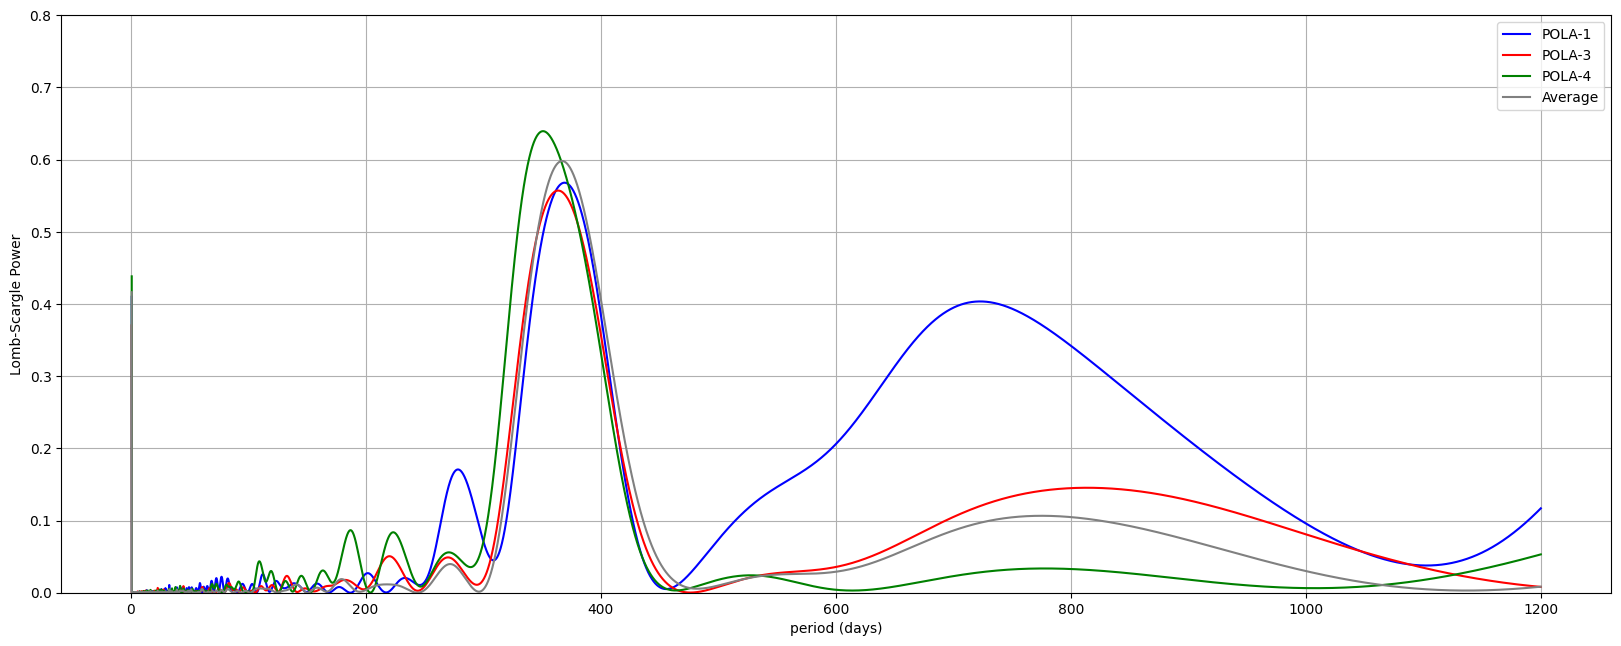

In [23]:
#------------- Plotting the periodograms for the 3 POLA and average together -----#

#------------- gatspy.LombScargle (normal)-------------#


from gatspy.periodic import LombScargle

periods = np.linspace(1,1200, 12000)
model1 = LombScargle(fit_offset=True).fit(m1, r1, er1)
power1 = model1.score(periods)
model3 = LombScargle(fit_offset=True).fit(m3, r3, er3)
power3 = model3.score(periods)
model4 = LombScargle(fit_offset=True).fit(m4, r4, er4)
power4 = model4.score(periods)
model = LombScargle(fit_offset=True).fit(ma, ra, era)
power = model.score(periods)


# plot the results
plt.rcParams["figure.figsize"] = (20,7.5)
fig, ax = plt.subplots()
ax.plot(periods, power1,color='blue', label='POLA-1')
ax.plot(periods, power3,color='red',  label='POLA-3')
ax.plot(periods, power4,color='green',label='POLA-4')
ax.plot(periods, power, color='grey', label='Average')
plt.legend()
ax.grid()
#plt.xscale('log')
#plt.yscale('log')
ax.set(ylim=(0, 0.8), xlabel='period (days)',  ylabel='Lomb-Scargle Power');
#ax.set(xlim=(10,1e3))

#------ finding peaks with the model API
model1.optimizer.quiet=True      #<------ this is to avoid verbose output
model3.optimizer.quiet=True      #<------ this is to avoid verbose output
model4.optimizer.quiet=True      #<------ this is to avoid verbose output
model.optimizer.quiet=True      #<------ this is to avoid verbose output
model1.optimizer.period_range = (50,1000)
model3.optimizer.period_range = (50,1000)
model4.optimizer.period_range = (50,1000)
model.optimizer.period_range = (50,1000)
pk1=model1.find_best_periods(4)
pk3=model3.find_best_periods(4)
pk4=model4.find_best_periods(4)
pk =model.find_best_periods(4)
print('Computed with model optimizer')
print('Peaks POLA-1: ',pk1)
print('Peaks POLA-3: ',pk3)
print('Peaks POLA-4: ',pk4)
print('Peaks POLA-A: ',pk)

#------ finding peaks from this smooth periodogram <--- with scipy.signal

import scipy.signal
#peaks  = scipy.signal.find_peaks(power,height=0.01)
print('\n\nComputed with scipy.signal')

print('\nPeaks POLA-1:')
peaks  = scipy.signal.find_peaks(power1,height=0.02)
ind=peaks[0]
height=peaks[1]
for i in range(0,len(ind)):
    print(i,ind[i],round(periods[ind[i]],1),round(power1[ind[i]],3))

print('\nPeaks POLA-3:')
peaks  = scipy.signal.find_peaks(power3,height=0.02)
ind=peaks[0]
height=peaks[1]
for i in range(0,len(ind)):
    print(i,ind[i],round(periods[ind[i]],1),round(power3[ind[i]],3))

print('\nPeaks POLA-4:')
peaks  = scipy.signal.find_peaks(power4,height=0.02)
ind=peaks[0]
height=peaks[1]
for i in range(0,len(ind)):
    print(i,ind[i],round(periods[ind[i]],1),round(power4[ind[i]],3))

print('\nPeaks AVERAGE:')
peaks  = scipy.signal.find_peaks(power,height=0.02)
ind=peaks[0]
height=peaks[1]
for i in range(0,len(ind)):
    print(i,ind[i],round(periods[ind[i]],1),round(power[ind[i]],3))


    
print ('Done.')

# Plotting the time series together with the model.
The plot shows the time series wrapped over one period only.

period =    367.3025839169283   --> the best peak
tfit =      0.0 ... 367.3025839169283   --> the linear array 
magfit =    33.23741825858479 ... 33.23741825858479   --> the model 
ma =        58636.08333333349 ... 59638.04166666651   --> the original time (julian cal)
phase =     0.6397245781288348 ... 0.3676071937317431   --> the phase [0,1] =(ma/peak)%1
phasefit =  0.0 ... 1.0   --> the phasefit [0,1]


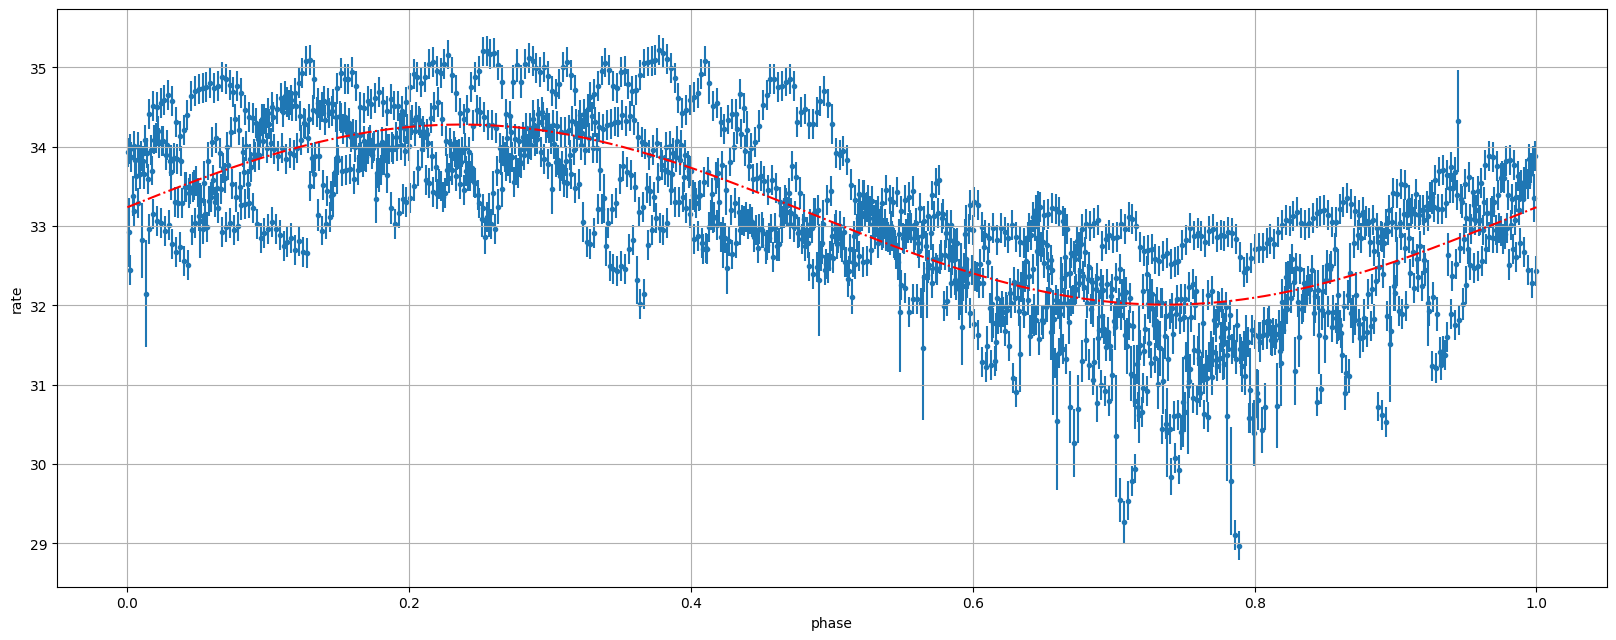

In [24]:
#plt.rcParams["figure.figsize"] = (20,7.5)

# Predict on a regular phase grid
period = model.best_period
print('period =   ' ,period,'  --> the best peak')
tfit = np.linspace(0, period, 1000)
print('tfit =     ',tfit[0],'...',tfit[999],'  --> the linear array ')
magfit = model.predict(tfit)
print('magfit =   ',magfit[0],'...',magfit[999],'  --> the model ')
print('ma =       ',ma[0],'...',ma[999],'  --> the original time (julian cal)')

# Plot the results
phase = (ma / period) % 1
phasefit = (tfit / period)
print('phase =    ',phase[0],'...',phase[999],'  --> the phase [0,1] =(ma/peak)%1')
print('phasefit = ',phasefit[0],'...',phasefit[999],'  --> the phasefit [0,1]')

fig, ax = plt.subplots()
ax.errorbar(phase, ra, era, fmt='.',         zorder=1)
ax.plot(phasefit, magfit, '-.', color='red', zorder=2)
ax.set(xlabel='phase', ylabel='rate')
ax.grid()
#ax.invert_yaxis()


# Plotting the full time series and the model.

Max fit =  34.27978369011888 , index= 951
date at max= 2022-01-11T00:00:00.000000
Done.


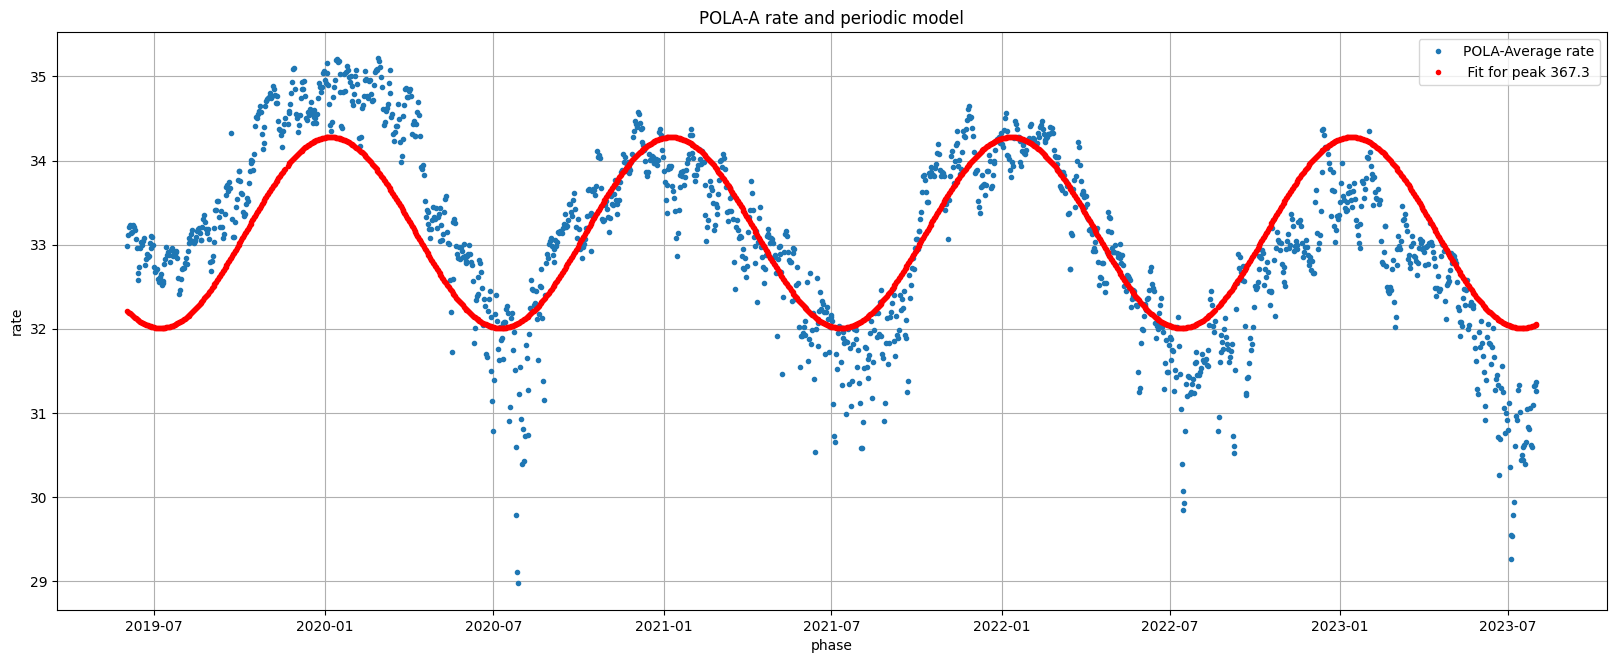

In [9]:
# Show  main fit and dates
periods = np.linspace(1,3000, 6000)
model = LombScargle(fit_offset=True).fit(ma, ra, era)
power = model.score(periods)
model.optimizer.quiet=True
model.optimizer.period_range = (50,1000)
#peaks = model.find_best_periods(1)

peak = model.best_period
fit = model.predict(ma) 
phase = (ma -ma[0]) / peak    
fig, ax = plt.subplots()
slabel= (' Fit for peak %5.1f' % peak)
plt.title('POLA-A rate and periodic model')
ax.plot(ta, ra,  '.', label='POLA-Average rate')
ax.plot(ta, fit, '.', color='red',label=slabel)
ax.set(xlabel='phase', ylabel='rate')
ax.legend()
ax.grid()

im=np.argmax(fit)
print('Max fit = ',max(fit), ', index=',im)
print('date at max=',ta[im])
print('Done.')

# Successive periodicities
Here, in a loop, we compute the next periodicity and we build the model. 
Subtracting the model from the time series allows to continue the loop and analyze the next degree of periodicity.
The peak optimizer needs reduced time intervals: for this reason the loop is divided in three parts:
- 15 peaks between 100 and 1200 time units
- 5 peaks between 900 and 1500
- 5 peaks between 1 and 100

Plots show:
- time series and 1st periodicity
- residual time series and last removed periodicity
- original time series and recontructed model

1  -- Removing fit for peak= 367.3025839169283 , max= 0.49249471403064093
2  -- Removing fit for peak= 783.4148853978883 , max= 0.38961677945867595
3  -- Removing fit for peak= 1424.8243559718971 , max= 0.07798618556786298
4  -- Removing fit for peak= 180.7808878587984 , max= 0.09042256888266752
5  -- Removing fit for peak= 220.13170272812792 , max= 0.06114547577231319
6  -- Removing fit for peak= 140.50159345988638 , max= 0.06030640965023561
7  -- Removing fit for peak= 560.530679933665 , max= 0.048032337449445114
8  -- Removing fit for peak= 326.1498874236089 , max= 0.047770821026551474
9  -- Removing fit for peak= 119.28008469591813 , max= 0.034063417328499636
10  -- Removing fit for peak= 830.4668304668305 , max= 0.030232200596656884
11  -- Removing fit for peak= 258.95973440027245 , max= 0.03152722993033149
12  -- Removing fit for peak= 110.52574210660174 , max= 0.03332176403418394
13  -- Removing fit for peak= 99.29818834666231 , max= 0.03445573092636308
14  -- Removing fit for p

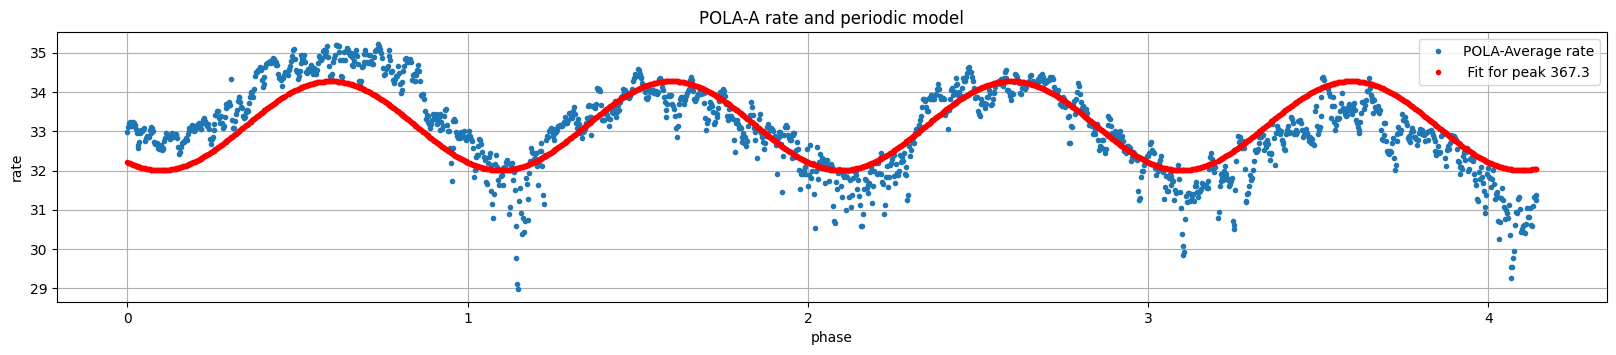

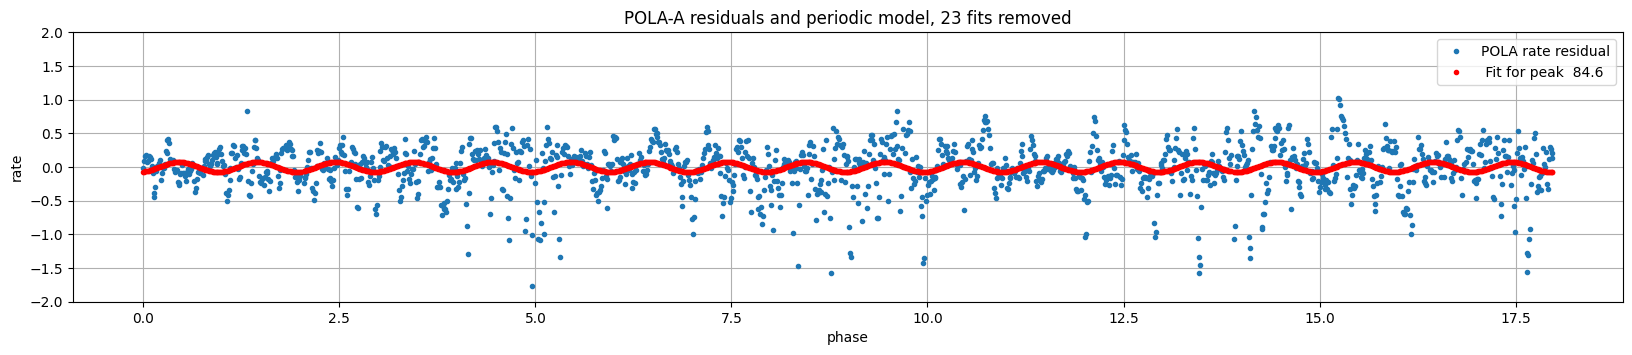

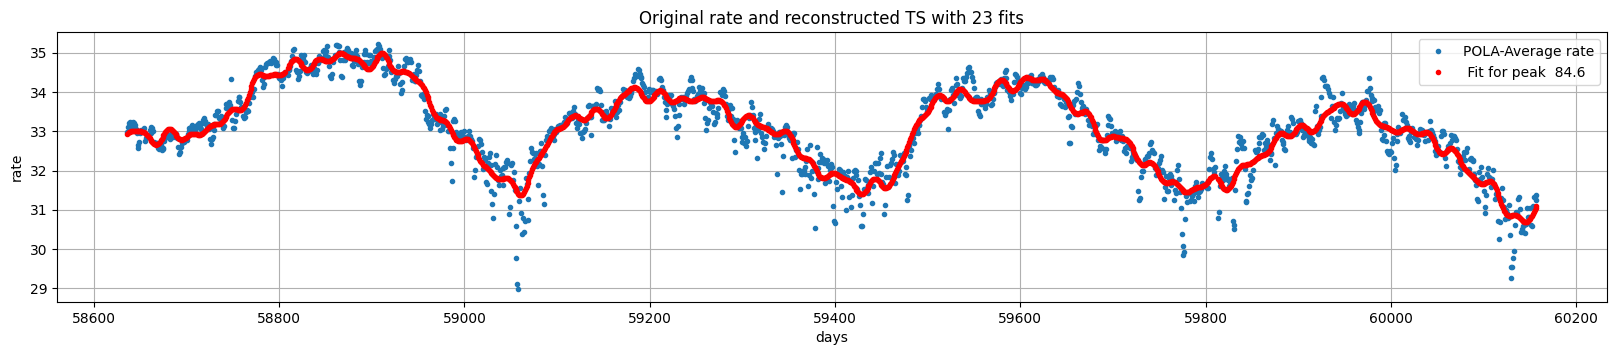

In [14]:
#------- removing components in a loop, with a function
#
# divided into three lops, to run the optimizer on different time windows
#

#model = LombScargleFast(fit_period=True)
#model.optimizer.period_range = (50,1000)
#model.fit(ma,ra,era)
#peaks = model.find_best_periods(1)

#model = LombScargleFast().fit(ma,ra,era)
#freq, power = model.periodogram_auto(nyquist_factor=nyquist)
#model.optimizer.period_range = (50,1000)
#peaks = model.find_best_periods(1)

periods = np.linspace(1,3000, 6000)
model = LombScargle(fit_offset=True).fit(ma, ra, era)
power = model.score(periods)
model.optimizer.quiet=True
model.optimizer.period_range = (50,1000)
#peaks = model.find_best_periods(1)

peak = model.best_period
fit = model.predict(ma) 
phase = (ma -ma[0]) / peak    
fig, ax = plt.subplots()
slabel= (' Fit for peak %5.1f' % peak)
plt.title('POLA-A rate and periodic model')
ax.plot(phase, ra,  '.', label='POLA-Average rate')
ax.plot(phase, fit, '.', color='red',label=slabel)
ax.set(xlabel='phase', ylabel='rate')
ax.legend()
ax.grid()

ts = ra       # <---- the time series
recon = fit   # <---- reconstructing the ts
peaks = [peak]# <---- collecting peaks in an array 

for i in range(15): #--- 0,1,2, ... , N-1
    #
    res = ts-fit  # <-- the residuals, after removing the fit
    # compute new periodogram on the residuals
    model = LombScargle(fit_offset=True).fit(ma, res, era)
    power = model.score(periods)
    powmax = max(power)
    print (i+1,' -- Removing fit for peak=',peak,', max=',powmax)
    model.optimizer.quiet=True
    model.optimizer.period_range = (100,1200)
    fit = model.predict(ma)
    peak = model.best_period
    phase = (ma -ma[0])/ peak    
    #
    show_plot=False
    if show_plot==True or i==19:
        fig, ax = plt.subplots()
        stitle='POLA-A residuals and periodic model, %d fits removed' % (i+1)
        #plt.title('POLA-A residuals and periodic model')
        plt.title(stitle)
        ax.plot(phase, res, '.',label='POLA rate residual')
        slabel= (' Fit for peak %5.1f' % peak)
        ax.plot(phase, fit, '.', color='red',label=slabel)
        ax.set(ylim=(-2,2),xlabel='phase', ylabel='rate')
        ax.legend()
        ax.grid()
    #
    #print ('Removing fit for peak=',peak)
    ts = res
    recon = recon+fit
    peaks.append(peak)


for j in range(5): #--- 0,1,2, ... , N-1
    #
    res = ts-fit  # <-- the residuals, after removing the fit
    # compute new periodogram on the residuals
    model = LombScargle(fit_offset=True).fit(ma, res, era)
    power = model.score(periods)
    powmax = max(power)
    print (j+1,' -- Removing fit for peak=',peak,', max=',powmax)
    model.optimizer.quiet=True
    model.optimizer.period_range = (900,1500)
    fit = model.predict(ma)
    peak = model.best_period
    phase = (ma -ma[0])/ peak    
    #
    ts = res
    recon = recon+fit
    peaks.append(peak)

for k in range(5): #--- 0,1,2, ... , N-1
    #
    res = ts-fit  # <-- the residuals, after removing the fit
    # compute new periodogram on the residuals
    model = LombScargle(fit_offset=True).fit(ma, res, era)
    power = model.score(periods)
    powmax = max(power)
    print (k+1,' -- Removing fit for peak=',peak,', max=',powmax)
    model.optimizer.quiet=True
    model.optimizer.period_range = (1,100)
    fit = model.predict(ma)
    peak = model.best_period
    phase = (ma -ma[0])/ peak    
    #
    show_plot=False
    if show_plot==True or k==4:
        fig, ax = plt.subplots()
        stitle='POLA-A residuals and periodic model, %d fits removed' % (k+j+i+1)
        #plt.title('POLA-A residuals and periodic model')
        plt.title(stitle)
        ax.plot(phase, res, '.',label='POLA rate residual')
        slabel= (' Fit for peak %5.1f' % peak)
        ax.plot(phase, fit, '.', color='red',label=slabel)
        ax.set(ylim=(-2,2),xlabel='phase', ylabel='rate')
        ax.legend()
        ax.grid()
    #
    #print ('Removing fit for peak=',peak)
    ts = res
    recon = recon+fit
    peaks.append(peak)

fig, ax = plt.subplots()
stitle= ('Original rate and reconstructed TS with %d fits' % (k+j+i+1))
plt.title(stitle)
ax.plot(ma, ra,  '.', label='POLA-Average rate')
ax.plot(ma, recon, '.', color='red',label=slabel)
ax.set(xlabel='days', ylabel='rate')
ax.legend()
ax.grid()

print(peaks)

# Evaluating the residuals

Work in progress.

count    1517.000000
mean       -0.020844
std         0.360370
min        -2.514328
25%        -0.187924
50%         0.018208
75%         0.202155
max         1.026350
dtype: float64


<Axes: >

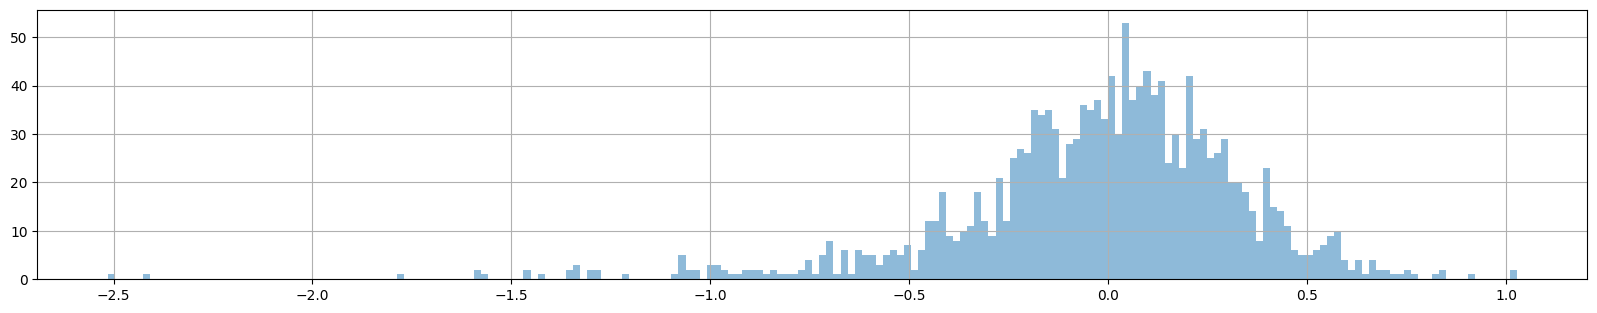

In [16]:
#-------- now we should evaluate if the residual is white noise
#The following conditions must be satisfied for a time series to be classified as white noise:
# - The average value (mean) is zero
# - Standard deviation is constant — it doesn’t change over time
# - The correlation between time series and its lagged version is not significant
#
from pandas import Series
from pandas.plotting import autocorrelation_plot
#x = autocorrelation_plot(res)
series = Series(res)
print(series.describe())
plt.rcParams["figure.figsize"] = (20,3.5)
#autocorrelation_plot(series)
series.hist(alpha=0.5,bins=200)
#plt.acorr(res, maxlags=3000) 

# Computing the RUNNING periodogram to evaluate changes in time

Important: adapt the time window to the sampling time and the length of the time series
(description)


Window length= 600 , Number of vectors= 918 , Total number of values= 1517
Reminder: resampling= 1d , nyquist= 0.5
XR shape =  (918, 600) , XRT shape =  (600, 918) , XRTF shape =  (600, 918)
Plotting the Running-Rate Matrix...


Text(0.5, 1.0, 'The Running-Rate Matrix for the Time Series')

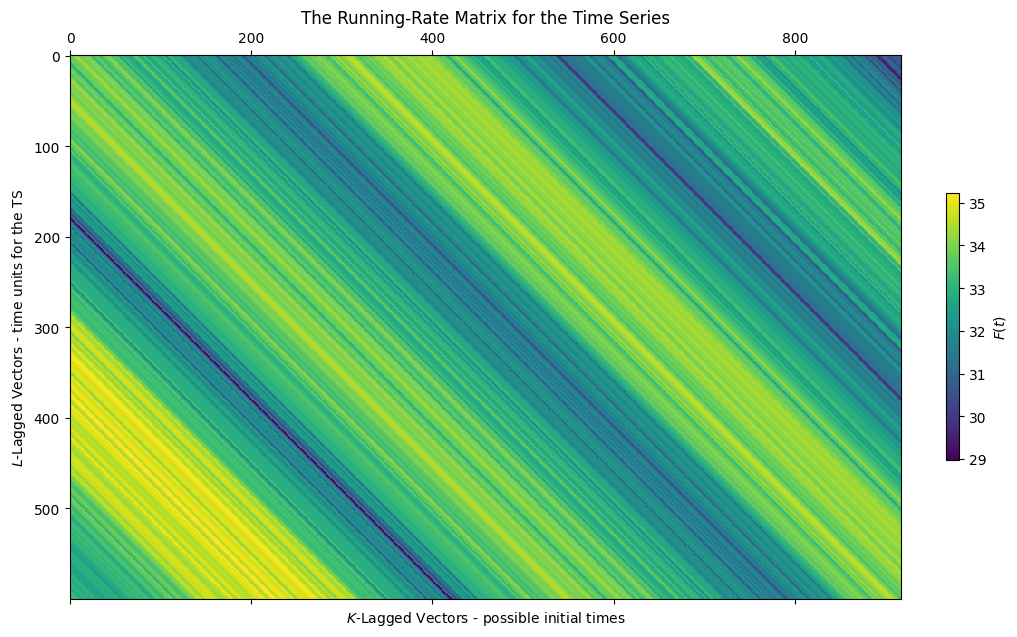

In [25]:
#---- building the running LSF 
#

#----First step: Building the running rate matrix, together with datetimes (because the rates are not uniformly sampled)
N = len(ra)
L = 600    # window length, set above  # <-----    adapt this according to data sampling
#L = 2400    # window length, set above  # <-----    adapt this according to data sampling
K = N-L+1  # number of columns in the trajectory matrix
# create the traj matrix by pulling the relevant subseries of F, and stacking them as columns
print('Window length=',L,', Number of vectors=',K,', Total number of values=',N)
print('Reminder: resampling=',resampling,', nyquist=',nyquist)


# note that i+L gives up to i+L-1, because numpy array upper bounds are excusive
XR = np.row_stack( [ ra[i:i+L] for i in range (0,K)] ) 
XE = np.row_stack( [era[i:i+L] for i in range (0,K)] ) 
XX = np.row_stack( [ ma[i:i+L] for i in range (0,K)] ) 

XRT=XR.T
XRTF=np.flipud(XRT)
#plotting the matrix
print ("XR shape = ",XR.shape,", XRT shape = ",XRT.shape,", XRTF shape = ",XRTF.shape)
print("Plotting the Running-Rate Matrix...")
ax = plt.matshow(XRTF)
plt.ylabel("$L$-Lagged Vectors - time units for the TS")
plt.xlabel("$K$-Lagged Vectors - possible initial times")
plt.colorbar(ax.colorbar, fraction=0.015)
ax.colorbar.set_label("$F(t)$")
plt.title("The Running-Rate Matrix for the Time Series")



In [26]:
#------------ calling K periodograms, and building the spectrogram like the gravitational waves studies
#periods = np.linspace(1,1200, 12000)
periods = np.linspace(1,1200, 1200)
A = np.zeros(1200)

#--now trying the LSP
for i in range(0,K):
    rrr=XR[i,:]
    eee=XE[i,:]
    mmm=XX[i,:]
    model = LombScargle(fit_offset=True).fit(mmm, rrr, eee)
    power = model.score(periods)
    A = np.row_stack( (A,power))
    if (int(i/100)*100 == i):
        print('...doing ',i,'/',K)
print ("A shape = ",A.shape)



...doing  0 / 918
...doing  100 / 918
...doing  200 / 918
...doing  300 / 918
...doing  400 / 918
...doing  500 / 918
...doing  600 / 918
...doing  700 / 918
...doing  800 / 918
...doing  900 / 918
A shape =  (919, 1200)


A shape =  (919, 1200)
K= 919
Plotting the Spectrogram Matrix...


Text(0.5, 1.0, 'The Spectrogram Matrix for AVERAGE rate Time Series')

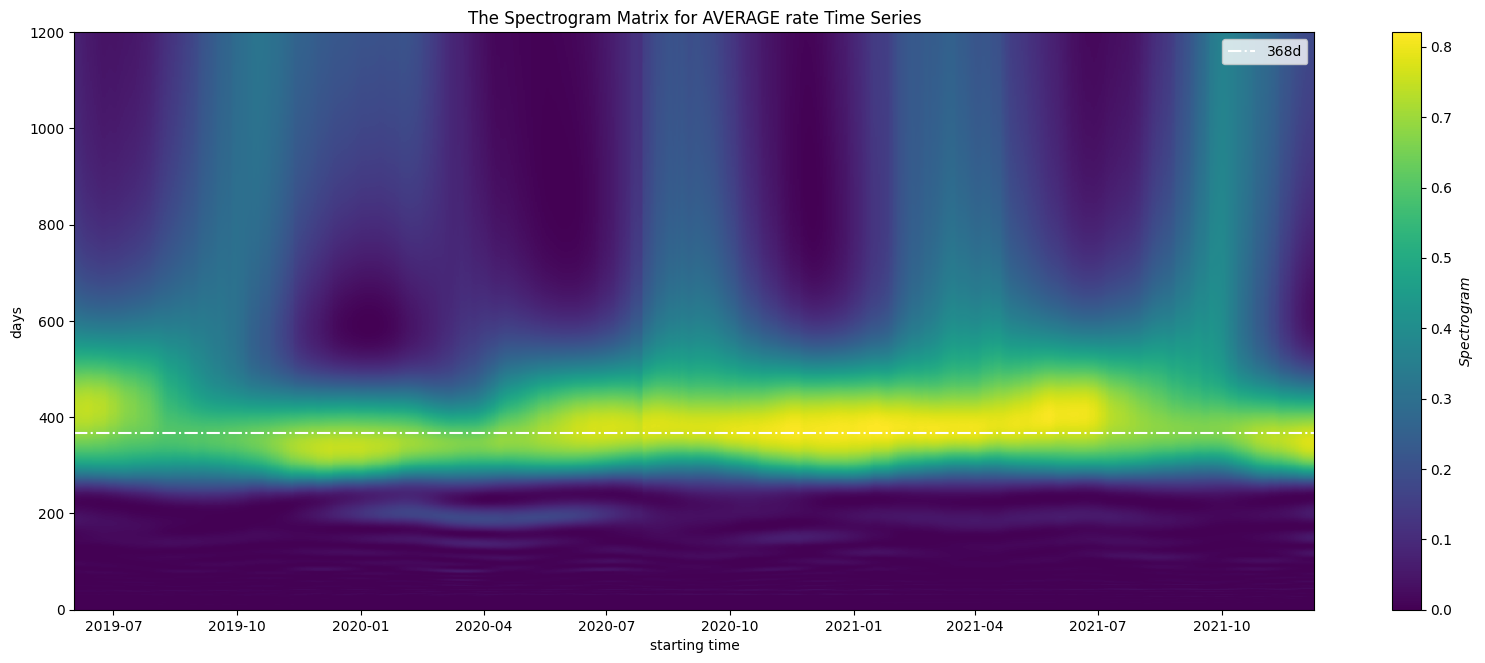

In [27]:
#plotting the matrix
print ("A shape = ",A.shape)

xa,ya=A.shape
AT=A.T
ATF=np.flipud(AT)

print("K=",xa)
print("Plotting the Spectrogram Matrix...")
#ax = plt.imshow(A,interpolation='nearest', aspect='auto',extent=[0,1200,322,1] ) #extent rewrites the axis
# oriented like the plots for gravitational waves
#ax = plt.imshow(ATF,interpolation='nearest', aspect='auto',extent=[0,xa,0,1200] ) #extent rewrites the axis
#ax = plt.imshow(ATF,interpolation='nearest', aspect='auto',extent=[ta[0],ta[K-1],0,1200] ) #extent rewrites the axis
#ax = plt.imshow(ATF,interpolation='nearest', aspect='auto',extent=[ma[0],ma[K],0,1200])
ax = plt.imshow(ATF,interpolation='nearest', aspect='auto',extent=[ta[0],ta[K],0,1200])


plt.colorbar(ax.colorbar)
ax.colorbar.set_label("$Spectrogram$")
plt.ylabel('days')
plt.xlabel('starting time')
plt.axhline(y=368,ls='-.',color='white',label='368d')
#xfmt = md.DateFormatter('%Y-%m')
#plt.xaxis.set_major_formatter(xfmt)
plt.legend()
plt.title("The Spectrogram Matrix for AVERAGE rate Time Series")


Plotting the Spectrogram Matrix...


Text(0.5, 1.0, 'The Spectrogram Matrix for AVERAGE rate Time Series')

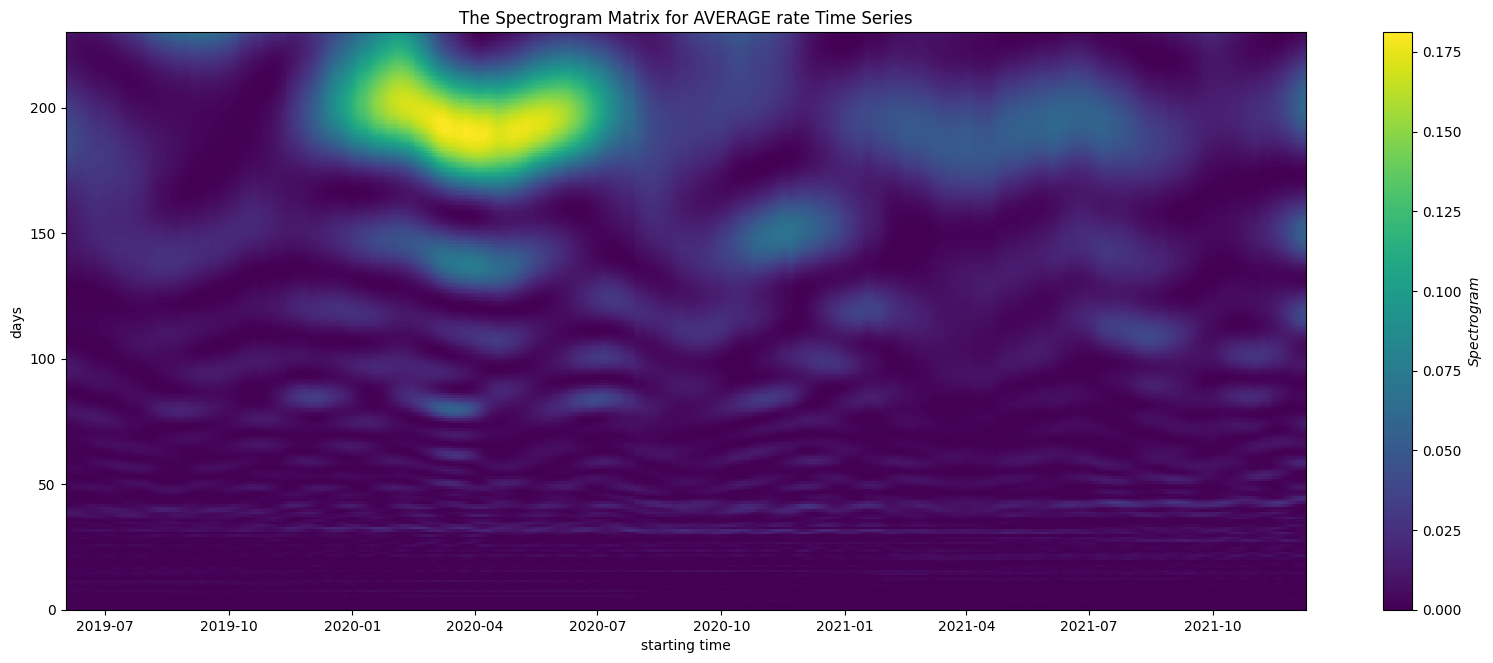

In [31]:
#-----plotting a ZOOM of the matrix
#print ("A shape = ",A.shape)

#xa,ya=A.shape
#AT=A.T
#ATF=np.flipud(AT)

#B = A[:,:230]
B = A[:,1:230]
BT = B.T
BTF = np.flipud(BT)

print("Plotting the Spectrogram Matrix...")
#ax = plt.imshow(A,interpolation='nearest', aspect='auto',extent=[0,1200,322,1] ) #extent rewrites the axis
# oriented like the plots for gravitational waves
#ax = plt.imshow(ATF,interpolation='nearest', aspect='auto',extent=[0,xa,0,1200] ) #extent rewrites the axis
ax = plt.imshow(BTF,interpolation='nearest', aspect='auto',extent=[ta[0],ta[K],0,230] ) #extent rewrites the axis

plt.colorbar(ax.colorbar)
ax.colorbar.set_label("$Spectrogram$")
plt.ylabel('days')
plt.xlabel('starting time')
#plt.axhline(y=368,ls='--',color='white',label='368')

plt.title("The Spectrogram Matrix for AVERAGE rate Time Series")


Plotting the Spectrogram Matrix...


Text(0.5, 1.0, 'The Spectrogram Matrix for AVERAGE rate Time Series')

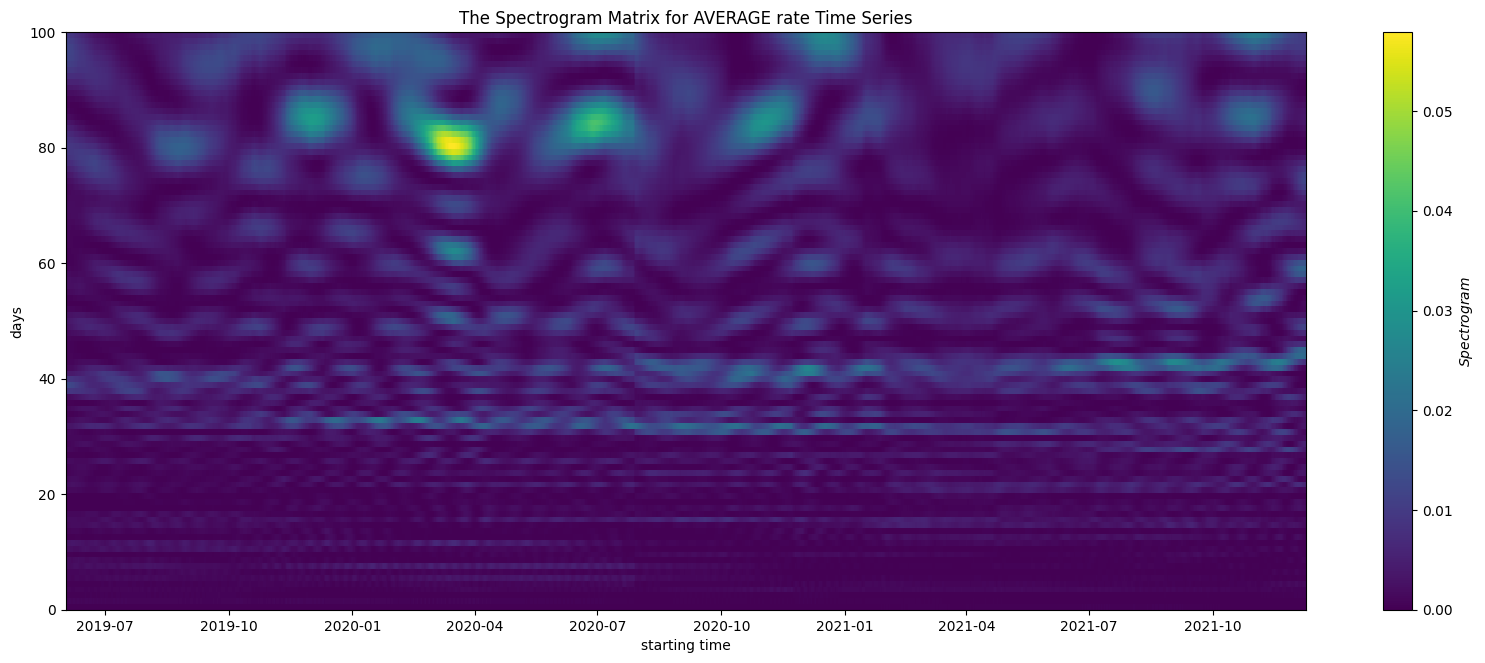

In [30]:
#-----plotting a ZOOM of the matrix -- zooming even more
#print ("A shape = ",A.shape)

#xa,ya=A.shape
#AT=A.T
#ATF=np.flipud(AT)

#C = A[:,:1000]
#C = A[:,25:75]
C = A[:,1:100]
CT = C.T
CTF = np.flipud(CT)

print("Plotting the Spectrogram Matrix...")
#ax = plt.imshow(A,interpolation='nearest', aspect='auto',extent=[0,1200,322,1] ) #extent rewrites the axis
# oriented like the plots for gravitational waves
#ax = plt.imshow(ATF,interpolation='nearest', aspect='auto',extent=[0,xa,0,1200] ) #extent rewrites the axis
ax = plt.imshow(CTF,interpolation='nearest', aspect='auto',extent=[ta[0],ta[K],0,100] ) #extent rewrites the axis
#ax = plt.imshow(CTF,interpolation='nearest', aspect='auto',extent=[ta[0],ta[K],25,75] ) #extent rewrites the axis

plt.colorbar(ax.colorbar)
ax.colorbar.set_label("$Spectrogram$")
plt.ylabel('days')
plt.xlabel('starting time')
#plt.axhline(y=368,ls='--',color='white',label='368')

plt.title("The Spectrogram Matrix for AVERAGE rate Time Series")
